# Building a Trading Robot
## Machine Learning Engineer Nanodegree
**Calvin Ku**
**September 27, 2016**

## Definition
### Project Overview
Problem with trading is that you never know when is the best time to buy or sell a stock, as you never know if the stock price will go up or go down in the future. This simple trading bot is an attempt to solve this problem.

Given the historical data of a stock, our chimp will tell you whether you should buy or sell or hold a particular stock (in our case, the JPM).

#### Data used in this project
The only data used in this project is the JPM historical data collected from Yahoo Finance. The data ranges from December 30, 1983 to September 27, 2016.

### Problem Statement
This project is about building a trading robot, or we can call it a trading bot. The trading bot is built to give the common user suggestions on whether to buy or sell or hold a particular stock on a particular trading day. The goal of this project is to build a trading bot that can beat a random monkey bot. Inpired by the famous saying of Princeton University professor Burton Malkiel in 1973 that "A blindfolded monkey throwing darts at a newspaper’s financial pages could select a portfolio that would do just as well as one carefully selected by experts” and the Forbes article [Any Monkey Can Beat the Market](http://www.forbes.com/sites/rickferri/2012/12/20/any-monkey-can-beat-the-market/#da3bf2d6e8b6), instead of competing on a portfolio basis, we set our battlefield on JPM.

We will use JPM as an example in this project but the same method can be applied to any stock. In the end we will evaluate our method by giving the monkey bot (which chooses the three actions equally on a random basis) and our chimp (the trading bot) 1000 dollars and see how they perform from year 2012 to the end of September 2016 on JPM.


### Metrics
In this project we use the cash in hand plus the portfolio value (number of shares in hand times the market price), the total assets as the metric. We also and define the reward function to be the ratio of the difference of the assets divided by the previous assets between the current state and the previous, i.e.:
$$
R(s_i) = \frac{Cash(s_{i + 1}) + PV(s_{i + 1}) - Cash(s_i) + PV(s_i)}{Cash(s_i) + PV(s_i)}
$$

This simple metric is in line with what we want the trading bot to achieve in that our ultimate goal is to make as much profit as possible given what we have put into the market, and it doesn't matter whether it's in cash or in shares.

## Analysis
### Data Exploration
#### First look
Let's first take a glance at our data and see if there's any missing values

In [1]:
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random

pd.set_option('display.max_columns', 50)

# dfSPY = pd.read_csv('allSPY.csv', index_col='Date', parse_dates=True, na_values = ['nan'])
dfJPM = pd.read_csv('JPM.csv', index_col='Date', parse_dates=True, na_values = ['nan'])

# del dfSPY.index.name
del dfJPM.index.name
# display(dfSPY)

start_date = '1983-12-30'
end_date = '2016-09-27'

dates = pd.date_range(start_date, end_date)

dfMain = pd.DataFrame(index=dates)
# dfMain = dfMain.join(dfSPY)
dfMain = dfMain.join(dfJPM)
dfMain.dropna(inplace=True)

print("Inspect missing values:")
display(dfMain.isnull().sum())
print(len(dfMain))

Inspect missing values:


Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

8256


and the first few lines:

In [2]:
display(dfMain.head())

,Open,High,Low,Close,Volume,Adj Close
1983-12-30,44.000008,44.500006,43.500014,44.000008,211500.0,2.602623
1984-01-03,43.937506,44.249986,43.624979,44.000008,385500.0,2.602623
1984-01-04,44.843758,45.874979,44.249986,45.874979,292500.0,2.713529
1984-01-05,46.812508,47.375008,46.250008,47.375008,344100.0,2.802256
1984-01-06,46.875014,47.375008,46.375021,46.875014,194400.0,2.772681


We can see that we have six columns: Open, High, Low, Close, Volume, Adj Close. The Adj Close is the closing price of that day adjusted for "future" dividends payout and splits. For our usage, we will need to adjust the rest of columns as well.

### Exploratory Visualization
Now let's have a look on the performance of JPM itself:

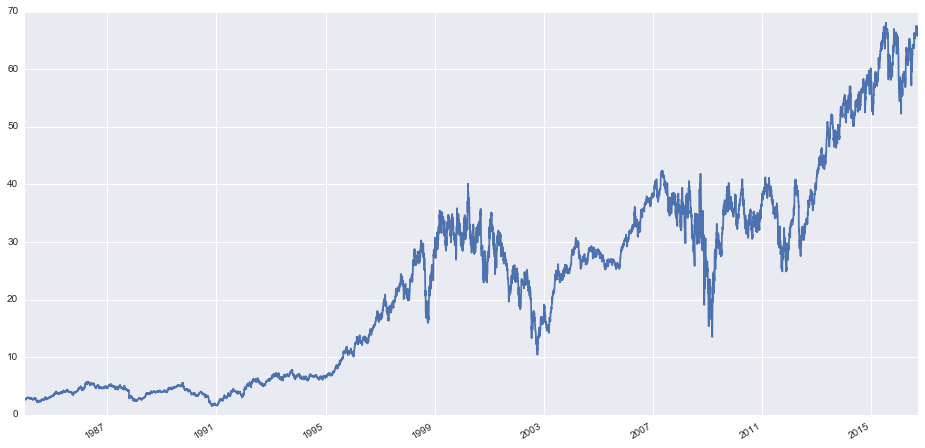

In [3]:
dfMain['Adj Close'].plot(figsize=(16, 8))

Starting from the beginning, the stock price generally has a upward trend, with a bad time from 2001 to 2003 and the crush at the end of 2008. 

### Algorithms and Techniques
#### Algorithms
The trading bot (from now on we refer to it as the *chimp*, coined with our wishful expectation that she will be smarter than the monkey trader) consists of two parts. In the first part we implement Q-learning and run it through the historical data for some number of iterations to construct the Q-table. The chimp can then go with the optimal policy by following the action of which the state-action pair has the maximum Q value. However, since the state space is vast and the coverage of the Q-table is very small, in the second part we use supervised learning to train on the Q-table and make predictions for the unseen states.

We also use K-fold cross-validation

##### Reinfocement learning
###### Q-learning
The idea of reinforcement learning is simple.
1. The chimp senses its environment (data of some sort)
2. The chimp takes an action
3. The chimp gets a reward for that action she took
4. The chimp "remembers" the association between the state-action pair and the reward, so next time when she is in the same situation, she'd carry out the action that she thinks best, under the condition that,
5. The chimp has a really good memory so she doesn't just remember the immediate reward for each state-action pair, she also remembers all the rewards that are prior to and lead to the current state-action pair so that she can maximize the total reward she gets.

One way to do this is to use a method called Q-learning. At the core of Q-learning is the Bellman equation.

In each iteration we use the Bellman equation to update the cell of our Q-table:
$$
Q(s, a) \longleftarrow (1 - \alpha) \ Q(s, a) + \alpha \ (R(s) + \gamma  \ max_{a'} Q(s', a'))
$$

where $\alpha$ is the learning rate, $R(s)$ the reward function, and $\gamma$ the discount factor.
And then the chimp will follow the policy:
$$
\pi(s) = argmax_{a}Q(s, a)
$$

Although we don't have the Q value of any state action pair to begin with, the reward function contains the "real" information and throughout the iterations that information will slowly propagate to each state-action pair. At some point the Q values will converge (hopefully), and we end up with a Q table in equilibrium.

###### Exploration-exploitation dilemma
However, there's a catch. How does the chimp know what to do before she has learned anything?

To begin with, the chimp goes out and explores the world, sensing new data as she goes, and taking actions.

One important concept of reinforcement learning is the **exploration-exploitation dilemma**. Essentially it means when we take an action, we have to choose between whether to explore new possibilities, or just to follow what we've known to be best, to the best of our knowledge. And of course, if we don't know much, then following that limited knowledge of ours wouldn't make much sense. On the other hand, if we've already known pretty much everything, then there's just not much to explore and wandering around mindlessly wouldn't make sense either.

To implement this concept, we want our chimp set out not having bias (not that she's got much anyways), so we introduce the variable $\epsilon$, which represents the possibility of the chimp taking random actions. Initially we set $\epsilon = 1$ , and gradually decreases its value as the chimp getting to know more and more about its environment.

##### Supervised learning with Adaboosted Trees
###### How boosted trees works
Adaboost is an ensemble method, which "ensembles" a bunch of weak learners (any model that works better than chance; in our case we use decision trees), and train them one by one in the following manner:

1. Train one weak learner and output the predictions
2. Identify the data where the predictions of the model did worst
3. Assign more weights to the mislabel/mispredicted data (for example, we can make more copies of them in our dataset)
4. Train the next weak learner with the re-weighted data
5. Keep repeating 1~4 until we are happy
6. We combine the output of all weak learners we get from 1~6 as our final output

In this report we use the decision tree as our weak learner.

###### Decision tree
In the training stage, a data point comes down and through the nodes of the decision tree. Each node classifies the data point and sends it to the next node. Say, for example we are classifying people to determine whether their annual income is above or below average, and one feature of our data is gender. And we will probably have values like male/female/other. Now say this data point is a female, then it will get sent down the path accordingly to the next node. The node at the bottom of the decision tree is sometimes referred to as a leaf. Our data point will end up in one of the leaves, and the label of the data point is going to mark that leaf. For example, if our data point is above income average, then we mark that leaf as "above count +1". At the end of the training, all leaves will be marked with labels above or below.

In the predicting stage, we run data down the decision tree and see which leaves they end up with. And then we assign the data the labels of the leaves accordingly.

### Benchmark
We test our chimp against 100,000 random monkeys and the patient trader we have defined earlier. Since these two naive traders don't get influenced by the media or manipulated by the market makers, they are proven to perform better than the average investor. We are happy as long as our chimp can perform better than the two naive traders.

## Methodology
### Data Preprocessing
#### Adjust prices


In [4]:
display(dfMain.head())

,Open,High,Low,Close,Volume,Adj Close
1983-12-30,44.000008,44.500006,43.500014,44.000008,211500.0,2.602623
1984-01-03,43.937506,44.249986,43.624979,44.000008,385500.0,2.602623
1984-01-04,44.843758,45.874979,44.249986,45.874979,292500.0,2.713529
1984-01-05,46.812508,47.375008,46.250008,47.375008,344100.0,2.802256
1984-01-06,46.875014,47.375008,46.375021,46.875014,194400.0,2.772681


As said earlier, we need to adjust the prices of Open, High, Low, Close, Volume. This can be done by getting the adjustment fact by dividing Adj Close by Close. We then multiply the prices by this factor, and divide the volume by this factor. 

In [5]:
# Adjust Open, High, Low, Volume
dfMain['Adj Factor'] = dfMain['Adj Close'] / dfMain['Close']

dfMain['Open'] = dfMain['Open'] * dfMain['Adj Factor']
dfMain['High'] = dfMain['High'] * dfMain['Adj Factor']
dfMain['Low'] = dfMain['Low'] * dfMain['Adj Factor']

dfMain['Volume'] = dfMain['Volume'] / dfMain['Adj Factor']

dfMain.drop(['Adj Factor'], axis=1, inplace=True)
display(dfMain.head())
display(dfMain.tail())

,Open,High,Low,Close,Volume,Adj Close
1983-12-30,2.602623,2.632198,2.573048,44.000008,3.575624e+06,2.602623
1984-01-03,2.598926,2.617409,2.580440,44.000008,6.517272e+06,2.602623
1984-01-04,2.652532,2.713529,2.617410,45.874979,4.945011e+06,2.713529
1984-01-05,2.768984,2.802256,2.735712,47.375008,5.817363e+06,2.802256
1984-01-06,2.772681,2.802256,2.743106,46.875014,3.286531e+06,2.772681


,Open,High,Low,Close,Volume,Adj Close
2016-09-21,66.839996,67.129997,66.309998,66.839996,14116800.0,66.839996
2016-09-22,66.989998,67.419998,66.839996,67.389999,12781700.0,67.389999
2016-09-23,67.389999,67.900002,67.180000,67.250000,13967400.0,67.250000
2016-09-26,66.599998,66.800003,65.540001,65.779999,16408100.0,65.779999
2016-09-27,65.410004,66.410004,65.110001,66.360001,13580600.0,66.360001


#### Features engineering using volume price analysis
Volume price analysis has been around for over 100 years, and there are many legendary traders who made themselves famous (and wealthy) using it. In addition to this, the basic principle behind it kind of makes sense on its own, that:
1. Price can only be moved by volume; large spread pushed by large volume and small spread by low volume
2. If it's not the case, then there's an anomaly, and you need to be cautious

But then people, especially practioners, tend to think of it as an art rather than science, in that even though you have some clues what's going on on the market, you still don't know what the best timing is. And it takes practice and practice until you "get it". 

For we data scientists, everything is science, including art. If a human can stare at the candlesticks telling you when to buy or sell, so can a computer. Thus the following features are extracted from the raw dataset:

For volume:
* -1d Volume
* -2d Volume
* -3d Volume
* -4d Volume
* -5d Volume
* 10d Average Volume
* 21d Average Volume
* 63d Average Volume

For price:
* -1d Spread
* -2d Spread
* -3d Spread
* -4d Spread
* -5d Spread
* 10d Spread
* 21d Spread
* 63d Spread

For wick:
* -1d upperwick/lowerwick
* -2d upperwick/lowerwick
* -3d upperwick/lowerwick
* -4d upperwick/lowerwick
* -5d upperwick/lowerwick
* 10d upperwick/lowerwick
* 21d upperwick/lowerwick
* 63d upperwick/lowerwick

To implement Q-learning we need to make the variables discrete. We use 100 day maximum and 100 day average to divide the above features and get relative levels of those features.

#### Trading price
We set the trading price of each trading day to be:
$$
Trade Price = 0.3 \ Open + 0.7 \ AdjClose
$$
This information is not available to the chimp. The properties of the chimp get updated with this information when she places an order. The portfolio value also gets updated using this price.

The reason for the slight lean to the closing price is because so that when a common user tries to follow the chimp suggestion, he or she still has time to do so.

In [6]:
# Price Engineering
# Get opens
dfMain['-1d_Open'] = dfMain['Open'].shift()
dfMain['-2d_Open'] = dfMain['Open'].shift(2)
dfMain['-3d_Open'] = dfMain['Open'].shift(3)
dfMain['-4d_Open'] = dfMain['Open'].shift(4)
dfMain['-5d_Open'] = dfMain['Open'].shift(5)
dfMain['-10d_Open'] = dfMain['Open'].shift(10)
dfMain['-21d_Open'] = dfMain['Open'].shift(21)
dfMain['-63d_Open'] = dfMain['Open'].shift(63)
dfMain['-100d_Open'] = dfMain['Open'].shift(100)

# Get adjCloses
dfMain['-1d_adjClose'] = dfMain['Adj Close'].shift()
dfMain['-2d_adjClose'] = dfMain['Adj Close'].shift(2)
dfMain['-3d_adjClose'] = dfMain['Adj Close'].shift(3)
dfMain['-4d_adjClose'] = dfMain['Adj Close'].shift(4)
dfMain['-5d_adjClose'] = dfMain['Adj Close'].shift(5)

# Get highs
dfMain['-1d_High'] = dfMain['High'].shift()
dfMain['-2d_High'] = dfMain['High'].shift(2)
dfMain['-3d_High'] = dfMain['High'].shift(3)
dfMain['-4d_High'] = dfMain['High'].shift(4)
dfMain['-5d_High'] = dfMain['High'].shift(5)
dfMain['10d_High'] = dfMain['High'].shift().rolling(window=10).max()
dfMain['21d_High'] = dfMain['High'].shift().rolling(window=21).max()
dfMain['63d_High'] = dfMain['High'].shift().rolling(window=63).max()
dfMain['100d_High'] = dfMain['High'].shift().rolling(window=100).max()

# Get lows
dfMain['-1d_Low'] = dfMain['Low'].shift()
dfMain['-2d_Low'] = dfMain['Low'].shift(2)
dfMain['-3d_Low'] = dfMain['Low'].shift(3)
dfMain['-4d_Low'] = dfMain['Low'].shift(4)
dfMain['-5d_Low'] = dfMain['Low'].shift(5)
dfMain['10d_Low'] = dfMain['Low'].shift().rolling(window=10).min()
dfMain['21d_Low'] = dfMain['Low'].shift().rolling(window=21).min()
dfMain['63d_Low'] = dfMain['Low'].shift().rolling(window=63).min()
dfMain['100d_Low'] = dfMain['Low'].shift().rolling(window=100).min()

In [7]:
dfMain['100d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=100).mean() * 1.5
dfMain['100d_Max_Vol'] = dfMain['Volume'].shift().rolling(window=100).max()

dfMain['Abs_Spread'] = np.abs(dfMain['Close'] - dfMain['Open'])
dfMain['Abs_Spread_Shift1'] = dfMain['Abs_Spread'].shift()

dfMain['100d_Avg_Spread'] = dfMain['Abs_Spread_Shift1'].rolling(window=100).mean() * 1.5
dfMain['100d_Max_Spread'] = dfMain['100d_High'] - dfMain['100d_Low']

dfMain.drop(['Abs_Spread_Shift1', 'Abs_Spread'], axis=1, inplace=True)

display(dfMain.tail())
display(dfMain.ix[datetime(2011, 12, 30)][['Open', 'Adj Close']])

,Open,High,Low,Close,Volume,Adj Close,-1d_Open,-2d_Open,-3d_Open,-4d_Open,-5d_Open,-10d_Open,-21d_Open,-63d_Open,-100d_Open,-1d_adjClose,-2d_adjClose,-3d_adjClose,-4d_adjClose,-5d_adjClose,-1d_High,-2d_High,-3d_High,-4d_High,-5d_High,10d_High,21d_High,63d_High,100d_High,-1d_Low,-2d_Low,-3d_Low,-4d_Low,-5d_Low,10d_Low,21d_Low,63d_Low,100d_Low,100d_Avg_Vol,100d_Max_Vol,100d_Avg_Spread,100d_Max_Spread
2016-09-21,66.839996,67.129997,66.309998,66.839996,14116800.0,66.839996,66.750000,66.150002,66.089996,66.290001,66.269997,67.160004,65.750000,62.463746,62.602664,66.459999,66.190002,65.820000,66.639999,66.400002,66.849998,66.639999,66.260002,66.930000,67.250000,67.680000,67.769997,67.769997,67.769997,66.239998,65.849998,65.440002,66.089996,66.209999,65.440002,65.410004,56.609318,56.609318,2.162303e+07,4.445207e+07,0.670126,11.160679
2016-09-22,66.989998,67.419998,66.839996,67.389999,12781700.0,67.389999,66.839996,66.750000,66.150002,66.089996,66.290001,67.220001,66.070000,63.207953,63.198027,66.839996,66.459999,66.190002,65.820000,66.639999,67.129997,66.849998,66.639999,66.260002,66.930000,67.680000,67.769997,67.769997,67.769997,66.309998,66.239998,65.849998,65.440002,66.089996,65.440002,65.440002,56.609318,56.609318,2.158722e+07,4.445207e+07,0.661166,11.160679
2016-09-23,67.389999,67.900002,67.180000,67.250000,13967400.0,67.250000,66.989998,66.839996,66.750000,66.150002,66.089996,67.029999,65.989998,60.012824,62.414134,67.389999,66.839996,66.459999,66.190002,65.820000,67.419998,67.129997,66.849998,66.639999,66.260002,67.430000,67.769997,67.769997,67.769997,66.839996,66.309998,66.239998,65.849998,65.440002,65.440002,65.440002,56.609318,56.609318,2.162404e+07,4.445207e+07,0.658286,11.160679
2016-09-26,66.599998,66.800003,65.540001,65.779999,16408100.0,65.779999,67.389999,66.989998,66.839996,66.750000,66.150002,66.139999,65.910004,58.256495,61.273014,67.250000,67.389999,66.839996,66.459999,66.190002,67.900002,67.419998,67.129997,66.849998,66.639999,67.900002,67.900002,67.900002,67.900002,67.180000,66.839996,66.309998,66.239998,65.849998,65.440002,65.440002,56.609318,56.609318,2.154451e+07,4.445207e+07,0.658198,11.290684
2016-09-27,65.410004,66.410004,65.110001,66.360001,13580600.0,66.360001,66.599998,67.389999,66.989998,66.839996,66.750000,66.110001,66.330002,58.732788,61.124170,65.779999,67.250000,67.389999,66.839996,66.459999,66.800003,67.900002,67.419998,67.129997,66.849998,67.900002,67.900002,67.900002,67.900002,65.540001,67.180000,66.839996,66.309998,66.239998,65.440002,65.440002,57.809971,56.609318,2.153319e+07,4.445207e+07,0.666044,11.290684


Open         29.013163
Adj Close    29.135839
Name: 2011-12-30 00:00:00, dtype: float64

In [8]:
def relative_transform(num):
    if 0 <= num < 0.25:
        return 1
    elif 0.25 <= num < 0.5:
        return 2
    elif 0.5 <= num < 0.75:
        return 3
    elif 0.75 <= num < 1:
        return 4
    elif 1 <= num:
        return 5
    elif -0.25 <= num < 0:
        return -1
    elif -0.5 <= num < -0.25:
        return -2
    elif -0.75 <= num < -0.5:
        return -3
    elif -1 <= num < -0.75:
        return -4
    elif num < -1:
        return -5
    else:
        num

# def relative_transform(num):
#     if 0 <= num < 0.25:
#         return "Very Low"
#     elif 0.25 <= num < 0.5:
#         return "Low"
#     elif 0.5 <= num < 0.75:
#         return "Average"
#     elif 0.75 <= num < 1:
#         return "High"
#     elif 1 <= num:
#         return "Very High"
#     elif -0.25 <= num < 0:
#         return "N-Very Low"
#     elif -0.5 <= num < -0.25:
#         return "N-Low"
#     elif -0.75 <= num < -0.5:
#         return "N-Average"
#     elif -1 <= num < -0.75:
#         return "N-High"
#     elif num < -1:
#         return "N-Very High"
#     else:
#         num

# Volume Engineering
# Get volumes
dfMain['-1d_Vol'] = dfMain['Volume'].shift()
dfMain['-2d_Vol'] = dfMain['Volume'].shift(2)
dfMain['-3d_Vol'] = dfMain['Volume'].shift(3)
dfMain['-4d_Vol'] = dfMain['Volume'].shift(4)
dfMain['-5d_Vol'] = dfMain['Volume'].shift(5)

# Get avg. volumes
dfMain['10d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=10).mean()
dfMain['21d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=21).mean()
dfMain['63d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=63).mean()

# Get relative volumes 1
dfMain['-1d_Vol1'] = dfMain['-1d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-2d_Vol1'] = dfMain['-2d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-3d_Vol1'] = dfMain['-3d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-4d_Vol1'] = dfMain['-4d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-5d_Vol1'] = dfMain['-5d_Vol'] / dfMain['100d_Avg_Vol']

dfMain['-1d_Vol1'] = dfMain['-1d_Vol1'].apply(relative_transform)
dfMain['-2d_Vol1'] = dfMain['-2d_Vol1'].apply(relative_transform)
dfMain['-3d_Vol1'] = dfMain['-3d_Vol1'].apply(relative_transform)
dfMain['-4d_Vol1'] = dfMain['-4d_Vol1'].apply(relative_transform)
dfMain['-5d_Vol1'] = dfMain['-5d_Vol1'].apply(relative_transform)

# Get relative avg. volumes 1 
dfMain['10d_Avg_Vol1'] = dfMain['10d_Avg_Vol'] / dfMain['100d_Avg_Vol']
dfMain['21d_Avg_Vol1'] = dfMain['21d_Avg_Vol'] / dfMain['100d_Avg_Vol']
dfMain['63d_Avg_Vol1'] = dfMain['63d_Avg_Vol'] / dfMain['100d_Avg_Vol']

dfMain['10d_Avg_Vol1'] = dfMain['10d_Avg_Vol1'].apply(relative_transform)
dfMain['21d_Avg_Vol1'] = dfMain['21d_Avg_Vol1'].apply(relative_transform)
dfMain['63d_Avg_Vol1'] = dfMain['63d_Avg_Vol1'].apply(relative_transform)

# Get relative volumes 2
dfMain['-1d_Vol2'] = dfMain['-1d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-2d_Vol2'] = dfMain['-2d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-3d_Vol2'] = dfMain['-3d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-4d_Vol2'] = dfMain['-4d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-5d_Vol2'] = dfMain['-5d_Vol'] / dfMain['100d_Max_Vol']

dfMain['-1d_Vol2'] = dfMain['-1d_Vol2'].apply(relative_transform)
dfMain['-2d_Vol2'] = dfMain['-2d_Vol2'].apply(relative_transform)
dfMain['-3d_Vol2'] = dfMain['-3d_Vol2'].apply(relative_transform)
dfMain['-4d_Vol2'] = dfMain['-4d_Vol2'].apply(relative_transform)
dfMain['-5d_Vol2'] = dfMain['-5d_Vol2'].apply(relative_transform)

In [9]:
# Spread Engineering
# Get spread

dfMain['-1d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-1d_Open']
dfMain['-2d_Spread'] = dfMain['-2d_adjClose'] - dfMain['-2d_Open']
dfMain['-3d_Spread'] = dfMain['-3d_adjClose'] - dfMain['-3d_Open']
dfMain['-4d_Spread'] = dfMain['-4d_adjClose'] - dfMain['-4d_Open']
dfMain['-5d_Spread'] = dfMain['-5d_adjClose'] - dfMain['-5d_Open']

dfMain['10d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-10d_Open']
dfMain['21d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-21d_Open']
dfMain['63d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-63d_Open']

# Get relative spread
dfMain['-1d_Spread'] = dfMain['-1d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-2d_Spread'] = dfMain['-2d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-3d_Spread'] = dfMain['-3d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-4d_Spread'] = dfMain['-4d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-5d_Spread'] = dfMain['-5d_Spread'] / dfMain['100d_Avg_Spread']

dfMain['-1d_Spread'] = dfMain['-1d_Spread'].apply(relative_transform)
dfMain['-2d_Spread'] = dfMain['-2d_Spread'].apply(relative_transform)
dfMain['-3d_Spread'] = dfMain['-3d_Spread'].apply(relative_transform)
dfMain['-4d_Spread'] = dfMain['-4d_Spread'].apply(relative_transform)
dfMain['-5d_Spread'] = dfMain['-5d_Spread'].apply(relative_transform)

dfMain['10d_Spread'] = dfMain['10d_Spread'] / dfMain['100d_Max_Spread']
dfMain['21d_Spread'] = dfMain['21d_Spread'] / dfMain['100d_Max_Spread']
dfMain['63d_Spread'] = dfMain['63d_Spread'] / dfMain['100d_Max_Spread']

dfMain['10d_Spread'] = dfMain['10d_Spread'].apply(relative_transform)
dfMain['21d_Spread'] = dfMain['21d_Spread'].apply(relative_transform)
dfMain['63d_Spread'] = dfMain['63d_Spread'].apply(relative_transform)

display(dfMain[['-1d_Spread', '-2d_Spread', '-3d_Spread', '-4d_Spread', '-5d_Spread', '21d_Spread']].tail())

,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,21d_Spread
2016-09-21,-2.0,1.0,-2.0,3.0,1.0,1.0
2016-09-22,1.0,-2.0,1.0,-2.0,3.0,1.0
2016-09-23,3.0,1.0,-2.0,1.0,-2.0,1.0
2016-09-26,-1.0,3.0,1.0,-2.0,1.0,1.0
2016-09-27,-5.0,-1.0,3.0,1.0,-2.0,-1.0


In [10]:
# Get wicks
def upperwick(open, adj_close, high):
    if high > open and high > adj_close:
        return True
    else:
        return False
def lowerwick(open, adj_close, low):
    if low < open and low < adj_close:
        return True
    else:
        return False
    
for index, row in dfMain.iterrows():
    dfMain.ix[index, '-1d_upperwick_bool'] = upperwick(dfMain.ix[index, '-1d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '-1d_High'])
    dfMain.ix[index, '-1d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-1d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '-1d_Low'])
    
    dfMain.ix[index, '-2d_upperwick_bool'] = upperwick(dfMain.ix[index, '-2d_Open'], dfMain.ix[index, '-2d_adjClose'], dfMain.ix[index, '-2d_High'])
    dfMain.ix[index, '-2d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-2d_Open'], dfMain.ix[index, '-2d_adjClose'], dfMain.ix[index, '-2d_Low'])
    
    dfMain.ix[index, '-3d_upperwick_bool'] = upperwick(dfMain.ix[index, '-3d_Open'], dfMain.ix[index, '-3d_adjClose'], dfMain.ix[index, '-3d_High'])
    dfMain.ix[index, '-3d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-3d_Open'], dfMain.ix[index, '-3d_adjClose'], dfMain.ix[index, '-3d_Low'])
    
    dfMain.ix[index, '-4d_upperwick_bool'] = upperwick(dfMain.ix[index, '-4d_Open'], dfMain.ix[index, '-4d_adjClose'], dfMain.ix[index, '-4d_High'])
    dfMain.ix[index, '-4d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-4d_Open'], dfMain.ix[index, '-4d_adjClose'], dfMain.ix[index, '-4d_Low'])
    
    dfMain.ix[index, '-5d_upperwick_bool'] = upperwick(dfMain.ix[index, '-5d_Open'], dfMain.ix[index, '-5d_adjClose'], dfMain.ix[index, '-5d_High'])
    dfMain.ix[index, '-5d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-5d_Open'], dfMain.ix[index, '-5d_adjClose'], dfMain.ix[index, '-5d_Low'])
    
    dfMain.ix[index, '10d_upperwick_bool'] = upperwick(dfMain.ix[index, '-10d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '10d_High'])
    dfMain.ix[index, '10d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-10d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '10d_Low'])
    
    dfMain.ix[index, '21d_upperwick_bool'] = upperwick(dfMain.ix[index, '-21d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '21d_High'])
    dfMain.ix[index, '21d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-21d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '21d_Low'])
    
    dfMain.ix[index, '63d_upperwick_bool'] = upperwick(dfMain.ix[index, '-63d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '63d_High'])
    dfMain.ix[index, '63d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-63d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '63d_Low'])
    
    dfMain.ix[index, '100d_upperwick_bool'] = upperwick(dfMain.ix[index, '-100d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '100d_High'])
    dfMain.ix[index, '100d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-100d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '100d_Low'])
    
# print(dfMain.head(20))

In [11]:
# Transform upper wicks
p_spread1d_up = dfMain['-1d_Spread'] >= 0 & dfMain['-1d_upperwick_bool']
n_spread1d_up = dfMain['-1d_Spread'] < 0 & dfMain['-1d_upperwick_bool']
p_spread2d_up = dfMain['-2d_Spread'] >= 0 & dfMain['-2d_upperwick_bool']
n_spread2d_up = dfMain['-2d_Spread'] < 0 & dfMain['-2d_upperwick_bool']
p_spread3d_up = dfMain['-3d_Spread'] >= 0 & dfMain['-3d_upperwick_bool']
n_spread3d_up = dfMain['-3d_Spread'] < 0 & dfMain['-3d_upperwick_bool']
p_spread4d_up = dfMain['-4d_Spread'] >= 0 & dfMain['-4d_upperwick_bool']
n_spread4d_up = dfMain['-4d_Spread'] < 0 & dfMain['-4d_upperwick_bool']
p_spread5d_up = dfMain['-5d_Spread'] >= 0 & dfMain['-5d_upperwick_bool']
n_spread5d_up = dfMain['-5d_Spread'] < 0 & dfMain['-5d_upperwick_bool']
p_spread10d_up = dfMain['10d_Spread'] >= 0 & dfMain['10d_upperwick_bool']
n_spread10d_up = dfMain['10d_Spread'] < 0 & dfMain['10d_upperwick_bool']
p_spread21d_up = dfMain['21d_Spread'] >= 0 & dfMain['21d_upperwick_bool']
n_spread21d_up = dfMain['21d_Spread'] < 0 & dfMain['21d_upperwick_bool']
p_spread63d_up = dfMain['63d_Spread'] >= 0 & dfMain['63d_upperwick_bool']
n_spread63d_up = dfMain['63d_Spread'] < 0 & dfMain['63d_upperwick_bool']

false1d_up = np.logical_not(dfMain['-1d_upperwick_bool'])
false2d_up = np.logical_not(dfMain['-2d_upperwick_bool'])
false3d_up = np.logical_not(dfMain['-3d_upperwick_bool'])
false4d_up = np.logical_not(dfMain['-4d_upperwick_bool'])
false5d_up = np.logical_not(dfMain['-5d_upperwick_bool'])
false10d_up = np.logical_not(dfMain['10d_upperwick_bool'])
false21d_up = np.logical_not(dfMain['21d_upperwick_bool'])
false63d_up = np.logical_not(dfMain['63d_upperwick_bool'])

dfMain.loc[p_spread1d_up, '-1d_upperwick'] = dfMain.loc[p_spread1d_up, '-1d_High'] - dfMain.loc[p_spread1d_up, '-1d_adjClose']
dfMain.loc[n_spread1d_up, '-1d_upperwick'] = dfMain.loc[n_spread1d_up, '-1d_High'] - dfMain.loc[n_spread1d_up, '-1d_Open']

dfMain.loc[p_spread2d_up, '-2d_upperwick'] = dfMain.loc[p_spread2d_up, '-2d_High'] - dfMain.loc[p_spread2d_up, '-2d_adjClose']
dfMain.loc[n_spread2d_up, '-2d_upperwick'] = dfMain.loc[n_spread2d_up, '-2d_High'] - dfMain.loc[n_spread2d_up, '-2d_Open']

dfMain.loc[p_spread3d_up, '-3d_upperwick'] = dfMain.loc[p_spread3d_up, '-3d_High'] - dfMain.loc[p_spread3d_up, '-3d_adjClose']
dfMain.loc[n_spread3d_up, '-3d_upperwick'] = dfMain.loc[n_spread3d_up, '-3d_High'] - dfMain.loc[n_spread3d_up, '-3d_Open']

dfMain.loc[p_spread4d_up, '-4d_upperwick'] = dfMain.loc[p_spread4d_up, '-4d_High'] - dfMain.loc[p_spread4d_up, '-4d_adjClose']
dfMain.loc[n_spread4d_up, '-4d_upperwick'] = dfMain.loc[n_spread4d_up, '-4d_High'] - dfMain.loc[n_spread4d_up, '-4d_Open']

dfMain.loc[p_spread5d_up, '-5d_upperwick'] = dfMain.loc[p_spread5d_up, '-5d_High'] - dfMain.loc[p_spread5d_up, '-5d_adjClose']
dfMain.loc[n_spread5d_up, '-5d_upperwick'] = dfMain.loc[n_spread5d_up, '-5d_High'] - dfMain.loc[n_spread5d_up, '-5d_Open']

dfMain.loc[p_spread10d_up, '10d_upperwick'] = dfMain.loc[p_spread10d_up, '10d_High'] - dfMain.loc[p_spread10d_up, '-1d_adjClose']
dfMain.loc[n_spread10d_up, '10d_upperwick'] = dfMain.loc[n_spread10d_up, '10d_High'] - dfMain.loc[n_spread10d_up, '-10d_Open']

dfMain.loc[p_spread21d_up, '21d_upperwick'] = dfMain.loc[p_spread21d_up, '21d_High'] - dfMain.loc[p_spread21d_up, '-1d_adjClose']
dfMain.loc[n_spread21d_up, '21d_upperwick'] = dfMain.loc[n_spread21d_up, '21d_High'] - dfMain.loc[n_spread21d_up, '-21d_Open']

dfMain.loc[p_spread63d_up, '63d_upperwick'] = dfMain.loc[p_spread63d_up, '63d_High'] - dfMain.loc[p_spread63d_up, '-1d_adjClose']
dfMain.loc[n_spread63d_up, '63d_upperwick'] = dfMain.loc[n_spread63d_up, '63d_High'] - dfMain.loc[n_spread63d_up, '-63d_Open']

# Get relative upperwick length
dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'] = dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'] / dfMain.loc[dfMain['-1d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'] = dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'] / dfMain.loc[dfMain['-2d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'] = dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'] / dfMain.loc[dfMain['-3d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'] = dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'] / dfMain.loc[dfMain['-4d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'] = dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'] / dfMain.loc[dfMain['-5d_upperwick_bool'], '100d_Avg_Spread']

dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'] = dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'] / dfMain.loc[dfMain['10d_upperwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'] = dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'] / dfMain.loc[dfMain['21d_upperwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'] = dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'] / dfMain.loc[dfMain['63d_upperwick_bool'], '100d_Max_Spread']

# Transform upperwick ratio to int
dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'] = dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'] = dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'] = dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'] = dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'] = dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'].apply(relative_transform)

dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'] = dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'] = dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'] = dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'].apply(relative_transform)

# Assign 0 to no-upperwick days
dfMain.loc[false1d_up, '-1d_upperwick'] = 0
dfMain.loc[false2d_up, '-2d_upperwick'] = 0
dfMain.loc[false3d_up, '-3d_upperwick'] = 0
dfMain.loc[false4d_up, '-4d_upperwick'] = 0
dfMain.loc[false5d_up, '-5d_upperwick'] = 0
dfMain.loc[false10d_up, '10d_upperwick'] = 0
dfMain.loc[false21d_up, '21d_upperwick'] = 0
dfMain.loc[false63d_up, '63d_upperwick'] = 0

In [12]:
# Transform lower wicks
p_spread1d_lw = dfMain['-1d_Spread'] >= 0 & dfMain['-1d_lowerwick_bool']
n_spread1d_lw = dfMain['-1d_Spread'] < 0 & dfMain['-1d_lowerwick_bool']
p_spread2d_lw = dfMain['-2d_Spread'] >= 0 & dfMain['-2d_lowerwick_bool']
n_spread2d_lw = dfMain['-2d_Spread'] < 0 & dfMain['-2d_lowerwick_bool']
p_spread3d_lw = dfMain['-3d_Spread'] >= 0 & dfMain['-3d_lowerwick_bool']
n_spread3d_lw = dfMain['-3d_Spread'] < 0 & dfMain['-3d_lowerwick_bool']
p_spread4d_lw = dfMain['-4d_Spread'] >= 0 & dfMain['-4d_lowerwick_bool']
n_spread4d_lw = dfMain['-4d_Spread'] < 0 & dfMain['-4d_lowerwick_bool']
p_spread5d_lw = dfMain['-5d_Spread'] >= 0 & dfMain['-5d_lowerwick_bool']
n_spread5d_lw = dfMain['-5d_Spread'] < 0 & dfMain['-5d_lowerwick_bool']
p_spread10d_lw = dfMain['10d_Spread'] >= 0 & dfMain['10d_lowerwick_bool']
n_spread10d_lw = dfMain['10d_Spread'] < 0 & dfMain['10d_lowerwick_bool']
p_spread21d_lw = dfMain['21d_Spread'] >= 0 & dfMain['21d_lowerwick_bool']
n_spread21d_lw = dfMain['21d_Spread'] < 0 & dfMain['21d_lowerwick_bool']
p_spread63d_lw = dfMain['63d_Spread'] >= 0 & dfMain['63d_lowerwick_bool']
n_spread63d_lw = dfMain['63d_Spread'] < 0 & dfMain['63d_lowerwick_bool']

false1d_lw = np.logical_not(dfMain['-1d_lowerwick_bool'])
false2d_lw = np.logical_not(dfMain['-2d_lowerwick_bool'])
false3d_lw = np.logical_not(dfMain['-3d_lowerwick_bool'])
false4d_lw = np.logical_not(dfMain['-4d_lowerwick_bool'])
false5d_lw = np.logical_not(dfMain['-5d_lowerwick_bool'])
false10d_lw = np.logical_not(dfMain['10d_lowerwick_bool'])
false21d_lw = np.logical_not(dfMain['21d_lowerwick_bool'])
false63d_lw = np.logical_not(dfMain['63d_lowerwick_bool'])

# Get lowerwick length
dfMain.loc[p_spread1d_lw, '-1d_lowerwick'] = dfMain.loc[p_spread1d_lw, '-1d_Open'] - dfMain.loc[p_spread1d_lw, '-1d_Low']
dfMain.loc[n_spread1d_lw, '-1d_lowerwick'] = dfMain.loc[n_spread1d_lw, '-1d_adjClose'] - dfMain.loc[n_spread1d_lw, '-1d_Low']

dfMain.loc[p_spread2d_lw, '-2d_lowerwick'] = dfMain.loc[p_spread2d_lw, '-2d_Open'] - dfMain.loc[p_spread2d_lw, '-2d_Low']
dfMain.loc[n_spread2d_lw, '-2d_lowerwick'] = dfMain.loc[n_spread2d_lw, '-2d_adjClose'] - dfMain.loc[n_spread2d_lw, '-2d_Low']

dfMain.loc[p_spread3d_lw, '-3d_lowerwick'] = dfMain.loc[p_spread3d_lw, '-3d_Open'] - dfMain.loc[p_spread3d_lw, '-3d_Low']
dfMain.loc[n_spread3d_lw, '-3d_lowerwick'] = dfMain.loc[n_spread3d_lw, '-3d_adjClose'] - dfMain.loc[n_spread3d_lw, '-3d_Low']

dfMain.loc[p_spread4d_lw, '-4d_lowerwick'] = dfMain.loc[p_spread4d_lw, '-4d_Open'] - dfMain.loc[p_spread4d_lw, '-4d_Low']
dfMain.loc[n_spread4d_lw, '-4d_lowerwick'] = dfMain.loc[n_spread4d_lw, '-4d_adjClose'] - dfMain.loc[n_spread4d_lw, '-4d_Low']

dfMain.loc[p_spread5d_lw, '-5d_lowerwick'] = dfMain.loc[p_spread5d_lw, '-5d_Open'] - dfMain.loc[p_spread5d_lw, '-5d_Low']
dfMain.loc[n_spread5d_lw, '-5d_lowerwick'] = dfMain.loc[n_spread5d_lw, '-5d_adjClose'] - dfMain.loc[n_spread5d_lw, '-5d_Low']

dfMain.loc[p_spread10d_lw, '10d_lowerwick'] = dfMain.loc[p_spread10d_lw, '-10d_Open'] - dfMain.loc[p_spread10d_lw, '10d_Low']
dfMain.loc[n_spread10d_lw, '10d_lowerwick'] = dfMain.loc[n_spread10d_lw, '-1d_adjClose'] - dfMain.loc[n_spread10d_lw, '10d_Low']

dfMain.loc[p_spread21d_lw, '21d_lowerwick'] = dfMain.loc[p_spread21d_lw, '-21d_Open'] - dfMain.loc[p_spread21d_lw, '21d_Low']
dfMain.loc[n_spread21d_lw, '21d_lowerwick'] = dfMain.loc[n_spread21d_lw, '-1d_adjClose'] - dfMain.loc[n_spread21d_lw, '21d_Low']

dfMain.loc[p_spread63d_lw, '63d_lowerwick'] = dfMain.loc[p_spread63d_lw, '-63d_Open'] - dfMain.loc[p_spread63d_lw, '63d_Low']
dfMain.loc[n_spread63d_lw, '63d_lowerwick'] = dfMain.loc[n_spread63d_lw, '-1d_adjClose'] - dfMain.loc[n_spread63d_lw, '63d_Low']

# Get relative lowerwick length
dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'] = dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'] / dfMain.loc[dfMain['-1d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'] = dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'] / dfMain.loc[dfMain['-2d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'] = dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'] / dfMain.loc[dfMain['-3d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'] = dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'] / dfMain.loc[dfMain['-4d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'] = dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'] / dfMain.loc[dfMain['-5d_lowerwick_bool'], '100d_Avg_Spread']

dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'] = dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'] / dfMain.loc[dfMain['10d_lowerwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'] = dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'] / dfMain.loc[dfMain['21d_lowerwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'] = dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'] / dfMain.loc[dfMain['63d_lowerwick_bool'], '100d_Max_Spread']

# Tranform lowerwick ratio to int
dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'] = dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'] = dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'] = dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'] = dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'] = dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'].apply(relative_transform)

dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'] = dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'] = dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'] = dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'].apply(relative_transform)

# Assign 0 to no-lowerwick days
dfMain.loc[false1d_lw, '-1d_lowerwick'] = 0
dfMain.loc[false2d_lw, '-2d_lowerwick'] = 0
dfMain.loc[false3d_lw, '-3d_lowerwick'] = 0
dfMain.loc[false4d_lw, '-4d_lowerwick'] = 0
dfMain.loc[false5d_lw, '-5d_lowerwick'] = 0
dfMain.loc[false10d_lw, '10d_lowerwick'] = 0
dfMain.loc[false21d_lw, '21d_lowerwick'] = 0
dfMain.loc[false63d_lw, '63d_lowerwick'] = 0

In [13]:
# dfMain.dropna(inplace=True)
display(dfMain[['-1d_lowerwick', '-2d_lowerwick', '-3d_lowerwick', '-4d_lowerwick', '-5d_lowerwick', '10d_lowerwick', '21d_lowerwick', '63d_lowerwick']].isnull().sum())

-1d_lowerwick    65
-2d_lowerwick    65
-3d_lowerwick    65
-4d_lowerwick    64
-5d_lowerwick    63
10d_lowerwick    82
21d_lowerwick    74
63d_lowerwick    34
dtype: int64

In [14]:
display(dfMain.tail())

,Open,High,Low,Close,Volume,Adj Close,-1d_Open,-2d_Open,-3d_Open,-4d_Open,-5d_Open,-10d_Open,-21d_Open,-63d_Open,-100d_Open,-1d_adjClose,-2d_adjClose,-3d_adjClose,-4d_adjClose,-5d_adjClose,-1d_High,-2d_High,-3d_High,-4d_High,-5d_High,...,-5d_lowerwick_bool,10d_upperwick_bool,10d_lowerwick_bool,21d_upperwick_bool,21d_lowerwick_bool,63d_upperwick_bool,63d_lowerwick_bool,100d_upperwick_bool,100d_lowerwick_bool,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick
2016-09-21,66.839996,67.129997,66.309998,66.839996,14116800.0,66.839996,66.750000,66.150002,66.089996,66.290001,66.269997,67.160004,65.750000,62.463746,62.602664,66.459999,66.190002,65.820000,66.639999,66.400002,66.849998,66.639999,66.260002,66.930000,67.250000,...,True,True,True,True,True,True,True,True,True,1.0,3.0,2.0,2.0,5.0,1.0,1.0,1.0,2.0,2.0,3.0,2.0,1.0,1.0,1.0,3.0
2016-09-22,66.989998,67.419998,66.839996,67.389999,12781700.0,67.389999,66.839996,66.750000,66.150002,66.089996,66.290001,67.220001,66.070000,63.207953,63.198027,66.839996,66.459999,66.190002,65.820000,66.639999,67.129997,66.849998,66.639999,66.260002,66.930000,...,True,True,True,True,True,True,True,True,True,2.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,4.0,2.0,2.0,3.0,2.0,1.0,1.0,3.0
2016-09-23,67.389999,67.900002,67.180000,67.250000,13967400.0,67.250000,66.989998,66.839996,66.750000,66.150002,66.089996,67.029999,65.989998,60.012824,62.414134,67.389999,66.839996,66.459999,66.190002,65.820000,67.419998,67.129997,66.849998,66.639999,66.260002,...,True,True,True,True,True,True,True,True,True,1.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,4.0,2.0,2.0,3.0,1.0,1.0,2.0
2016-09-26,66.599998,66.800003,65.540001,65.779999,16408100.0,65.779999,67.389999,66.989998,66.839996,66.750000,66.150002,66.139999,65.910004,58.256495,61.273014,67.250000,67.389999,66.839996,66.459999,66.190002,67.900002,67.419998,67.129997,66.849998,66.639999,...,True,True,True,True,True,True,True,True,True,4.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,2.0,1.0,1.0,1.0
2016-09-27,65.410004,66.410004,65.110001,66.360001,13580600.0,66.360001,66.599998,67.389999,66.989998,66.839996,66.750000,66.110001,66.330002,58.732788,61.124170,65.779999,67.250000,67.389999,66.839996,66.459999,66.800003,67.900002,67.419998,67.129997,66.849998,...,True,True,True,True,True,True,True,True,True,2.0,4.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,4.0,2.0,1.0,1.0,1.0


In [15]:
dfMain['Trade Price'] = dfMain['Open'] * 0.3 + dfMain['Adj Close'] * 0.7
print(dfMain[['Trade Price', 'Open', 'Adj Close']].head())

            Trade Price      Open  Adj Close
1983-12-30     2.602623  2.602623   2.602623
1984-01-03     2.601514  2.598926   2.602623
1984-01-04     2.695230  2.652532   2.713529
1984-01-05     2.792274  2.768984   2.802256
1984-01-06     2.772681  2.772681   2.772681


In [16]:
display(dfMain.columns)

Index([u'Open', u'High', u'Low', u'Close', u'Volume', u'Adj Close',
       u'-1d_Open', u'-2d_Open', u'-3d_Open', u'-4d_Open',
       ...
       u'63d_upperwick', u'-1d_lowerwick', u'-2d_lowerwick', u'-3d_lowerwick',
       u'-4d_lowerwick', u'-5d_lowerwick', u'10d_lowerwick', u'21d_lowerwick',
       u'63d_lowerwick', u'Trade Price'],
      dtype='object', length=106)

In [17]:
dfMain.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', \
             '-1d_Vol', '-2d_Vol', '-3d_Vol', '-4d_Vol', '-5d_Vol', '10d_Avg_Vol', '21d_Avg_Vol', '63d_Avg_Vol', \
             '-1d_Open', '-2d_Open', '-3d_Open', '-4d_Open', '-5d_Open', '-10d_Open', '-21d_Open', '-63d_Open', '-100d_Open',  \
             '-1d_adjClose', '-2d_adjClose', '-3d_adjClose', '-4d_adjClose', '-5d_adjClose', \
             '-1d_High', '-2d_High', '-3d_High', '-4d_High', '-5d_High', '10d_High', '21d_High', '63d_High', '100d_High',  \
             '-1d_Low', '-2d_Low', '-3d_Low', '-4d_Low', '-5d_Low', '10d_Low', '21d_Low', '63d_Low', '100d_Low',  \
             '100d_Avg_Vol', '100d_Max_Vol', '100d_Avg_Spread', '100d_Max_Spread', \
             '-1d_upperwick_bool', '-2d_upperwick_bool', '-3d_upperwick_bool', '-4d_upperwick_bool', '-5d_upperwick_bool', '10d_upperwick_bool', '21d_upperwick_bool', '63d_upperwick_bool', '100d_upperwick_bool', \
             '-1d_lowerwick_bool', '-2d_lowerwick_bool', '-3d_lowerwick_bool', '-4d_lowerwick_bool', '-5d_lowerwick_bool', '10d_lowerwick_bool', '21d_lowerwick_bool', '63d_lowerwick_bool', '100d_lowerwick_bool'], \
            axis=1, inplace=True)

In [18]:
display(dfMain.columns)
dfMain.ix[:,:-1]

dfMain.dropna(inplace=True)

print(dfMain.isnull().sum())

display(dfMain.head())

Index([u'-1d_Vol1', u'-2d_Vol1', u'-3d_Vol1', u'-4d_Vol1', u'-5d_Vol1',
       u'10d_Avg_Vol1', u'21d_Avg_Vol1', u'63d_Avg_Vol1', u'-1d_Vol2',
       u'-2d_Vol2', u'-3d_Vol2', u'-4d_Vol2', u'-5d_Vol2', u'-1d_Spread',
       u'-2d_Spread', u'-3d_Spread', u'-4d_Spread', u'-5d_Spread',
       u'10d_Spread', u'21d_Spread', u'63d_Spread', u'-1d_upperwick',
       u'-2d_upperwick', u'-3d_upperwick', u'-4d_upperwick', u'-5d_upperwick',
       u'10d_upperwick', u'21d_upperwick', u'63d_upperwick', u'-1d_lowerwick',
       u'-2d_lowerwick', u'-3d_lowerwick', u'-4d_lowerwick', u'-5d_lowerwick',
       u'10d_lowerwick', u'21d_lowerwick', u'63d_lowerwick', u'Trade Price'],
      dtype='object')

-1d_Vol1         0
-2d_Vol1         0
-3d_Vol1         0
-4d_Vol1         0
-5d_Vol1         0
10d_Avg_Vol1     0
21d_Avg_Vol1     0
63d_Avg_Vol1     0
-1d_Vol2         0
-2d_Vol2         0
-3d_Vol2         0
-4d_Vol2         0
-5d_Vol2         0
-1d_Spread       0
-2d_Spread       0
-3d_Spread       0
-4d_Spread       0
-5d_Spread       0
10d_Spread       0
21d_Spread       0
63d_Spread       0
-1d_upperwick    0
-2d_upperwick    0
-3d_upperwick    0
-4d_upperwick    0
-5d_upperwick    0
10d_upperwick    0
21d_upperwick    0
63d_upperwick    0
-1d_lowerwick    0
-2d_lowerwick    0
-3d_lowerwick    0
-4d_lowerwick    0
-5d_lowerwick    0
10d_lowerwick    0
21d_lowerwick    0
63d_lowerwick    0
Trade Price      0
dtype: int64


,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-3.0,-2.0,-3.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.498467
1984-05-24,2.0,1.0,5.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-3.0,-3.0,-3.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.504116
1984-05-25,5.0,2.0,1.0,5.0,1.0,5.0,3.0,3.0,5.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-2.0,-3.0,-3.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.489427
1984-05-29,2.0,5.0,2.0,1.0,5.0,5.0,3.0,3.0,1.0,5.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-3.0,-3.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,2.422755
1984-05-30,2.0,2.0,5.0,2.0,1.0,5.0,3.0,3.0,1.0,1.0,5.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-3.0,-3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.267943


In [19]:
print("-1d_VolAvg1.5 Var: {}".format(np.var(dfMain['-1d_Vol1'])))
print("-1d_VolMax Var: {}".format(np.var(dfMain['-1d_Vol2'])))

print("10d_VolAvg1.5 Var: {}".format(np.var(dfMain['10d_Avg_Vol1'])))
print("21d_VolAvg1.5 Var: {}".format(np.var(dfMain['21d_Avg_Vol1'])))
print("63d_VolAvg1.5 Var: {}".format(np.var(dfMain['63d_Avg_Vol1'])))
print("\n")

print("-1d_Spread Var: {}".format(np.var(dfMain['-1d_Spread'])))
print("10d_Spread Var: {}".format(np.var(dfMain['10d_Spread'])))
print("21d_Spread Var: {}".format(np.var(dfMain['21d_Spread'])))
print("63d_Spread Var: {}".format(np.var(dfMain['63d_Spread'])))
print("\n")

print("-1d_upperwick Var: {}".format(np.var(dfMain['-1d_upperwick'])))
print("10d_upperwick Var: {}".format(np.var(dfMain['10d_upperwick'])))
print("21d_upperwick Var: {}".format(np.var(dfMain['21d_upperwick'])))
print("63d_upperwick Var: {}".format(np.var(dfMain['63d_upperwick'])))
print("\n")

print("-1d_lowerwick Var: {}".format(np.var(dfMain['-1d_lowerwick'])))
print("10d_lowerwick Var: {}".format(np.var(dfMain['10d_lowerwick'])))
print("21d_lowerwick Var: {}".format(np.var(dfMain['21d_lowerwick'])))
print("63d_lowerwick Var: {}".format(np.var(dfMain['63d_lowerwick'])))


-1d_VolAvg1.5 Var: 1.14531550171
-1d_VolMax Var: 0.682164563931
10d_VolAvg1.5 Var: 0.695425155399
21d_VolAvg1.5 Var: 0.499789102088
63d_VolAvg1.5 Var: 0.123762017678


-1d_Spread Var: 1.11733284089
10d_Spread Var: 1.75052946215
21d_Spread Var: 2.58334960906
63d_Spread Var: 4.65430521878


-1d_upperwick Var: 0.157222897972
10d_upperwick Var: 0.0709857358508
21d_upperwick Var: 0.147321985866
63d_upperwick Var: 0.413770053717


-1d_lowerwick Var: 0.138975771259
10d_lowerwick Var: 0.0843144267942
21d_lowerwick Var: 0.181603938381
63d_lowerwick Var: 0.516349947481


In [20]:
data_full = dfMain
# data_full.to_csv('data_full.csv')

## Implementation
We divide this section into the training section and the testing section.

In the training section, we first set up the benchmarks (the monkey and the patient trader), to see how they perform throughout the training dataset. And then see how much can our chimp can fit the data.

In the testing section, we let them compete again, this time using completely new dataset.

As mentioned earlier, we assume the trading price to be 30% of the Adjusted Open plus 70% of the Adjusted Close, as a simulation of someone trading near the closing time. Due to the limitation of our hardware and the nature of the time series data (so that we can't go with the usual train-CV-test way), we would like to start with a backtest within a shorter range of time. We will use the data from May 23, 1984 to June 30, 2016 as our base training data and roll forward as time goes and backtest from July 1, 2016, to September 27, 2016.

Note that in our simulation, without loss of generality, we set the transaction cost to be 0 to simplify our problem.

### Training section
This training section essentially serves as a proof of concept that the chimp can really maximize her profit given enough of exposure to the data. It also demonstrates the potential profit one can make in a period of time.

#### The Patient Trader
If we were given 1000 dollars from May 23, 1984 and went all in, holding until June 30, 2016, 
we would have made 26430.6 dollars (principal included) at the end of September. This can be verified from below:

##### Start
###### Initial Condition
$Cash_{init} = 1000.00$

$Share_{init} = 0$

$PV_{init} = 0$

$Trading \ Price_{init} = 2.4985$

----------------

$Share_{start} = floor(\frac{1000.00}{2.4985}) = 400$

$PV_{start} = 2.4985 \cdot 400 = 999.40$

$Cash_{start} = Cash_{init} - PV_{start} = 1000.00 - 999.4 = 0.60$

$Total \ Assets_{start} = Cash_{start} + PV_{start} = 0.60 + 999.4 = 1000.00$

##### End
###### Final Condition
$Cash_{end} = 0.60$

$Share_{end} = 400$

$Trading \ Price_{end} = 65.410004 \times 0.3 + 66.360001 \times 0.7 = 66.075$

----------------

$PV_{end} = 66.0750 \cdot 400 = 26430$

$Total \ Assets_{start}  = Cash_{end} + PV_{end} = 0.60+ 26430 = 26430.6$

We can calculate the annual ROI by solving the following equation for $r$:
$$
(1 + r)^{8095/252} = 26.4306
$$

$$
\Longrightarrow r = 0.1073137 \approx 10.73\%
$$

#### The Monkey
We use a `MonkeyBot` class which will place one and only one order randomly everyday. We iterate it through the time frame we choose 100,000 times and we get the following distribution:


In [22]:
import random
import time

class MonkeyBot(object):
    def __init__(self, dfEnv, cash=1000, share=0, pv=0, now_yes_share=0):
        self.cash = cash
        self.share = share
        self.pv = pv
        self.pv_history_list = []
        self.env = dfEnv

    def buy(self, stock_price):
        num_affordable = int(self.cash // stock_price)
        self.cash = self.cash - stock_price * num_affordable
        self.share = self.share + num_affordable
        self.pv = stock_price * self.share

    def sell(self, stock_price):
        self.cash = self.cash + stock_price * self.share
        self.pv = 0
        self.share = 0

    def hold(self, stock_price):
        self.pv = stock_price * self.share

    def reset(self):
        self.cash = 1000
        self.share = 0
        self.pv = 0

    def yes_share(self):
        # Represent chimp asset in state_action
        if self.share > 0:
            return 1
        else:
            return 0

    def make_decision(self, x):
        random_choice = random.choice([1, 2])

        if random_choice == 0:
            self.hold(x)
        elif random_choice == 1:
            self.buy(x)
        else:
            self.sell(x)

        return self.pv # for frame-wise operation

    def simulate(self, iters):
        for i in range(iters):
            self.env['Monkey PV'] = self.env['Trade Price'].apply(self.make_decision)
            self.pv_history_list.append(self.env.ix[-1, 'Monkey PV'] + self.cash)
        


/Users/calvinku/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Monkey: 100000 times simulation took 8608.732728 seconds
100000 iterations took 8608.88182807 seconds


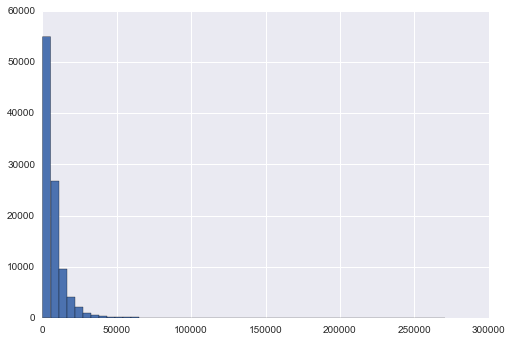

In [27]:
monkey = MonkeyBot(data_full.ix[datetime(1983, 5, 23):datetime(2016, 6, 30), :])

start_time = time.time()
iters = 100000

monkey.simulate(iters)
plt.hist(monkey.pv_history_list, bins=50)

print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))

In [28]:
display(pd.Series(monkey.pv_history_list).describe())

count    100000.000000
mean       7306.830621
std        7916.130919
min         119.181380
25%        2750.339286
50%        4962.576866
75%        8938.043167
max      270919.516481
dtype: float64


where the mean is 7306.83 and the median is 4962.58. Using the mean, to get the ROI we can simply do the same calculation again as we did for the patient trader:

$$
(1 + r)^{8095/252} = 7.306
$$

$$
\Longrightarrow r = 0.06386527 \approx 6.39\%
$$

#### The Chimp
Now comes our chimp. Across the 3500 rounds of iterations we linearly decrease the chance of our chimp going random (from 1 to 0.001) so that she can explore the data a bit to form her own opinion. With each iteration we can see that the chimp is making more and more profit along the way. 

In [23]:
from collections import defaultdict
from datetime import datetime, timedelta
from copy import deepcopy

from sklearn import cross_validation
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import grid_search

class ChimpBot(MonkeyBot):
    """An agent that learns to drive in the smartcab world."""
    # valid_actions = ['Buy', 'Sell', 'Hold']
    valid_actions = ['Buy', 'Sell']

    num_trial = 500
    trial_counter = 0 # For getting the trial number

    random_rounds = 3500 # Number of rounds where the bot chooses to go monkey

    trial_meta_info = {} # For monitoring what happens in each trial

    epsilon = 1
    gamma = 0.75
    random_reward = [0]

    random_counter = 0
    policy_counter = 0

    track_key1 = {'Sell': 0, 'Buy': 0, 'Hold': 0}
    track_key2 = {'Sell': 0, 'Buy': 0, 'Hold': 0}

    track_random_decision = {'Sell': 0, 'Buy': 0, 'Hold': 0}

    reset_counter = 0

    def __init__(self, dfEnv, cash=1000, share=0, pv=0, now_yes_share=0):
        super(ChimpBot, self).__init__(dfEnv, cash, share, pv, now_yes_share)
        # sets self.cash = 1000
        # sets self.share = 0
        # sets self.pv = 0
        # sets self.pv_history_list = []
        # sets self.env = dfEnv
        # implements buy(self, stock_price)
        # implements sell(self, stock_price)
        # implements hold(self)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        self.now_yes_share = 0
        self.now_action = ''
        # self.now_q = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        self.q_df_columns = list(self.env.columns)
        self.q_df_columns.pop()
        self.q_df_columns.extend(['Yes Share', 'Action', 'Q Value'])
        self.q_df = pd.DataFrame(columns=self.q_df_columns)
        self.q_dict = defaultdict(lambda: (0, 0)) # element of q_dict is (state, act): (q_value, t)
        self.q_dict_analysis = defaultdict(lambda: (0, 0))

        self.negative_reward = 0
        self.n_reward_hisotry = []
        self.net_reward = 0

        self.reset_counter = 0

        # Smartcab use only
        # self.penalty = False
        # self.num_step = 0 # Number of steps for each trial; get reset each time a new trial begins

    def make_q_df(self):
        result_dict = defaultdict(list)

        for index, row in self.q_dict.iteritems():
            for i in range(len(self.q_dict.keys()[0])):
                column_name = 'col' + str(i + 1)
                result_dict[column_name].append(index[i])
            result_dict['Q'].append(self.q_dict[index][0])

        self.q_df = pd.DataFrame(result_dict)
        q_df_column_list = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14', 'col15', 'col16', 'col17', 'col18', 'col19', 'col20', 'col21', 'col22', 'col23', 'col24', 'col25', 'col26', 'col27', 'col28', 'col29', 'col30', 'col31', 'col32', 'col33', 'col34', 'col35', 'col36', 'col37', 'col38', 'col39', 'Q']
        self.q_df = self.q_df[q_df_column_list]

        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        arr_int = np.vectorize(str_float_int)

        self.q_df['col39'] = self.q_df['col39'].apply(transfer_action)
        self.q_df.ix[:, :-1] = self.q_df.ix[:, :-1].apply(arr_int)

    def split_q_df(self):
        self.q_df_X = self.q_df.ix[:, :-1]
        self.q_df_y = self.q_df.ix[:, -1]
        # self.X_train, self.X_test, self.y_train, self.y_test = cross_validation.train_test_split(self.q_df_X, self.q_df_y, test_size=0.1, random_state=0)

    def train_on_q_df(self):
        reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=25), n_estimators=50, random_state=0)
        self.q_reg = reg
        self.q_reg = self.q_reg.fit(self.q_df_X, self.q_df_y)

    def update_q_model(self):
#         print("Updating Q model...")
        start_time = time.time()
        self.make_q_df()
        self.split_q_df()
        self.train_on_q_df()
#         print("Update took {} seconds".format(time.time() - start_time))

    def from_state_action_predict_q(self, state_action):
        state_action = [state_action]

        pred_q = self.q_reg.predict(state_action)

        return pred_q

    def yes_share(self):
        # Represent chimp asset in state_action
        if self.share > 0:
            return 1
        else:
            return 0

    def max_q(self, now_row):
        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        now_row2 = list(now_row)
        now_row2.append(self.now_yes_share)
        max_q = ''
        q_compare_dict = {}

        if len(now_row2) > 38:
            raise ValueError("Got ya bastard! @ MaxQ")

        # Populate the q_dict
        for act in set(self.valid_actions):
            now_row2.append(act)
            now_row_key = tuple(now_row2)

            _ = self.q_dict[now_row_key]

            # # K-Q Algorithm
            # if np.random.choice(2, p = [0.9, 0.1]) == 1 and len(self.q_dict) > 30000:
            # if _[1] == 0 and np.random.choice(2, p = [0.7, 0.3]) == 1 and len(self.q_dict) > 30000:
            try:
                self.q_reg
            except AttributeError:
                pass
                # print('No q_reg yet...going with default.')
            else:
                if _[1] == 0:
                    # print("Dreaming mode...")
                    # start_time = time.time()
                    # self.update_q_model()

                    single_X = np.array(now_row_key)
                    # print(single_X)
                    arr_int = np.vectorize(str_float_int)
                    single_X[-1] = transfer_action(single_X[-1])
                    single_X = arr_int(single_X)
                    single_X = single_X.reshape(1, -1)
                    pred_q = self.q_reg.predict(single_X)
                    dreamed_q = (1 - (1 / (self.q_dict[now_row_key][1] + 1))) * self.q_dict[now_row_key][0] + (1 / (self.q_dict[now_row_key][1] + 1)) * pred_q[0]
                    self.q_dict[now_row_key] = (dreamed_q, self.q_dict[now_row_key][1] + 1)
                    # print("Q-dreamed: {0} for Act: {1}, taking {2} seconds.".format(self.q_dict[now_row_key], act, time.time() - start_time))

            # print(act, self.q_dict[now_row_key])

            q_compare_dict[now_row_key] = self.q_dict[now_row_key]
            now_row2.pop()

        try:
            max(q_compare_dict.iteritems(), key=lambda x:x[1])
        except ValueError:
            print("Wrong Q Value in Q Compare Dict!")
        else:
            key, qAndT = max(q_compare_dict.iteritems(), key=lambda x:x[1])
            # print("Action: {0}, with Q-value: {1}".format(key[-1], qAndT[0]))
            return key[-1], qAndT[0], qAndT[1]

    def q_update(self):
        # print("Data Index: {}".format(self.now_env_index))
        now_states = list(self.now_row)
        # now_states = list(now_states)
        now_states.pop() # disregard the Trade Price

        prev_states = list(self.prev_states)

        if len(prev_states) > 37:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.prev_states!!!")

        prev_states.append(self.prev_yes_share)
        prev_states.append(self.prev_action)
        prev_states_key = tuple(prev_states)

        if len(prev_states_key) > 39:
            raise ValueError("Got ya bastard! @ Q_Update")

        q_temp = self.q_dict[prev_states_key]

        q_temp0 = (1 - (1 / (q_temp[1] + 1))) * q_temp[0] + (1 / (q_temp[1] + 1)) * (self.reward + self.gamma * self.max_q(now_states)[1])

        if prev_states_key[:-1] == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High', 'Yes'):
            self.track_key1[prev_states_key[-1]] += 1
        elif prev_states_key[:-1] == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High', 'No'):
            self.track_key2[prev_states_key[-1]] += 1
        # elif prev_states_key[:-1] == ('Very High', 'Very High', 'Very High', 'Very High', 'Very High', 'Very High', 'Average', 'High', 'Average', 'Average', 'Average', 'Low', 'Average', 'Very Low', 'Low', 'N-Very Low', 'N-Very Low', 'N-Very Low', 'N-Very Low', 'Very Low', 'Very Low', 'Average', 'Very Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Low', 'Very Low', 'Average', 'No'):
        #     self.track_key2[prev_states_key[-1]] += 1

        self.q_dict[prev_states_key] = (q_temp0, q_temp[1] + 1)
        # For analysis purpose
        self.q_dict_analysis[prev_states_key] = (q_temp0, self.prev_env_index)
        # print("Now Action: {}".format())
        # print(prev_states_key)
        return (self.q_dict[prev_states_key])

    def policy(self, now_row):
        return self.max_q(now_row)[0]

    def reset(self):
        # Portfolio change over iterations
        self.pv_history_list.append(self.pv + self.cash)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        self.cash = 1000
        self.share = 0
        self.pv = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        if self.epsilon - 1/self.random_rounds > 0.001: # Epislon threshold: 0.01
            self.random_counter += 1
            self.epsilon = self.epsilon - 1/self.random_rounds
        else:
            self.epsilon = 0.001 # Epislon threshold: 0.1
            self.policy_counter += 1

        self.net_reward = 0

        self.reset_counter += 1

        if self.reset_counter % 3500 == 0:
            self.update_q_model()

        # self.num_step = 0 # Recalculate the steps for the new trial
        # self.penalty = False
        # self.fail = False

    def make_decision(self, now_row):
        return self.policy(now_row)

    def update(self):
        # Update state
        now_states = list(self.now_row)

        if len(now_states) > 38:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.now_row!!!")

        # now_states = list(now_states)
        # print(type(self.now_row))
        now_states.pop() # disregard the Trade Price

        if len(now_states) > 37:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after pop!!!")

        # Exploitation-exploration decisioning
        random.seed(datetime.now())
        self.decision = np.random.choice(2, p = [self.epsilon, 1 - self.epsilon]) # decide to go random or with the policy
        # self.decision = 0 # Force random mode

        # print("Random decision: {0}, Epislon: {1}".format(self.decision, self.epsilon))
        # print("What the FUCK?!")
        if self.decision == 0: # if zero, go random
            random.seed(datetime.now())
            action = random.choice(self.valid_actions)
            if tuple(now_states) == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High'):
                self.track_random_decision[action] += 1
        else: # else go with the policy
            # print("now_states: {}".format(now_states))
            self.now_yes_share = self.yes_share()
            action = self.make_decision(now_states)

        if len(now_states) > 37:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after make_decision!!!")

        # print("Now Action Real: {}".format(action))
        # Execute action and get reward
        if action == 'Buy':
            # print(self.now_row)
            self.buy(self.now_row[-1])
        elif action == 'Sell':
            # print(self.now_row)
            self.sell(self.now_row[-1])
        elif action == 'Hold':
            # print(self.now_row)
            self.hold(self.now_row[-1])
        else:
            raise ValueError("Wrong action man!")

        try:
            self.prev_states
        except AttributeError:
            print("Running the first time...no prevs exist.")
        else:
            self.reward = ((self.cash - self.prev_cash) + (self.pv - self.prev_pv)) / (self.prev_cash + self.prev_pv)
            self.q_update()

        self.prev_states = now_states

        if len(now_states) > 37:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the now_states!!!")

        self.now_action = action
        self.prev_action = action
        self.prev_yes_share = self.now_yes_share
        self.prev_env_index = deepcopy(self.now_env_index)
        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        # if len(self.q_dict) > 20000:
        #     self.update_q_model()

        try:
            self.now_env_index, self.now_row = self.iter_env.next()
        except StopIteration:
            pass
            # print("End of data.")
        else:
            pass

        # if reward < 0:
        #     self.penalty = True

        try:
            _ = self.reward
        except AttributeError:
            print("No reward yet...0 assigned.")
            self.reward = 0
        # print "ChimpBot.update(): Action: {0} at Price: {1}, Cash: {2}, Num_Share: {3}, Cash + PV = {4}, Reward = {5}".format(action, self.now_row[-1], self.cash, self.share, self.cash + self.pv, self.reward)  # [debug]
        # print('Portfolio + Cash: {}'.format(self.cash + self.pv))
        # print("================================")



In [40]:
from collections import defaultdict
from copy import deepcopy

# Start simulation for the chimp
num_iter = 3500
day_count = 0
pv_history_list = []

chimp = ChimpBot(data_full.ix[datetime(1983, 5, 23):datetime(2016, 6, 30), :])

start_time = time.time()

for i in range(num_iter):
    for l in range(len(chimp.env)):
        chimp.update()
    pv_history_list.append(chimp.cash + chimp.pv)
    chimp.reset()

print("{0} rounds of training took {1} seconds".format(num_iter, time.time() - start_time))

print(pv_history_list[-1])

# Convert Q-Table to Dataframe from trained chimp (full)
result_dict = defaultdict(list)
for index, row in chimp.q_dict_analysis.iteritems():
    for i in range(len(chimp.q_dict_analysis.keys()[0])):
        column_name = 'col' + str(i + 1)
        result_dict[column_name].append(index[i])
    result_dict['Q'].append(chimp.q_dict_analysis[index][0])
    result_dict['Date'].append(chimp.q_dict_analysis[index][1])

q_df = pd.DataFrame(result_dict)

Running the first time...no prevs exist.
No reward yet...0 assigned.
3500 rounds of training took 8914.058882 seconds
1.84955136522e+26


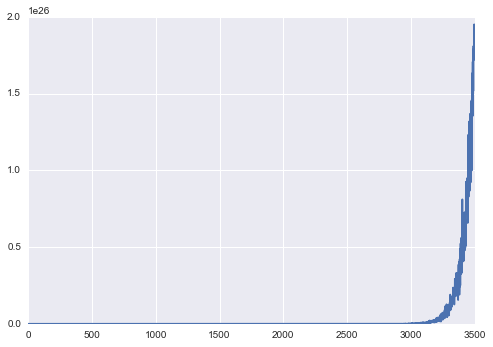

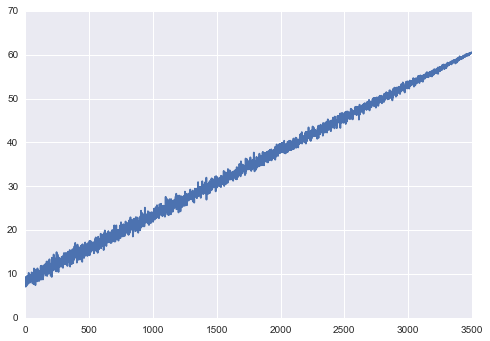

In [42]:
pd.Series(pv_history_list).plot()
plt.figure()
np.log(pd.Series(pv_history_list)).plot()

However, we can also see that the Q values are in no way near to convergence. This is due to the vastness of the state-action space. Unfortuntely we do not have enough resource to see them converge. Still, this gives us a clear idea that her policy function though not optimzal, is indeed improving fast.

Just for fun, let's look at the annual ROI:

$$
(1 + r)^{8095/252} = 1.84955136522 \times 10^26
$$

$$
	\Longrightarrow r = 5.572073 \approx 557.21\%
$$

Now it's time to find out if we can somewhat generalize this in the new data.


### Testing section
Now lets first set up the benchmarks for our target time period (from July 1, 2016 to Semptember 27, 2016). 

#### The Patient Trader
##### Start
###### Initial Condition
$Cash_{init} = 1000.00$

$Share_{init} = 0$

$PV_{init} = 0$

$Trading \ Price_{init} = 61.379999$

----------------

$Share_{start} = floor(\frac{1000.00}{61.38}) = 16$

$PV_{start} = 61.38 \cdot 16 = 982.08$

$Cash_{start} = Cash_{init} - PV_{start} = 1000.00 - 982.08 = 17.92$

$Total \ Assets_{start} = Cash_{start} + PV_{start} = 17.92 + 982.08 = 1000.00$

##### End
###### Final Condition
$Cash_{end} = 17.92$
$Share_{end} = 16$
$Trading \ Price_{end} = 66.0750019$

----------------

$PV_{end} = 66.08 \cdot 16 = 1057.28$

$Total \ Assets_{start}  = Cash_{end} + PV_{end} = 17.92 + 1057.28 = 1075.2$

We can calculate the annual ROI by solving the following equation for $r$:
$$
(1 + r)^{61/252} = 1.0752
$$

$$
\Longrightarrow r = 0.3492324 \approx 34.92\%
$$

#### The Monkey

In [ ]:
monkey_test = MonkeyBot(data_full.ix[datetime(2016, 7, 1):, :])

start_time = time.time()
iters = 100000

monkey_test.simulate(iters)

print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))

/Users/calvinku/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
plt.hist(monkey_test.pv_history_list, bins=50)

In [ ]:
statistics = pd.Series(monkey_test.pv_history_list)
print(statistics.describe())
print(statistics.mean() + 1.645 * statistics.std())

#### The Chimp

In [ ]:
pv_history_list = []
action_list = []
q_df = None

def main_simulate():
# Initiating data and the chimp
    dfFull = data_full
    train_size = 8095
    date_range = dfFull.index[train_size:] # Using one-year data to predict one day
    print(date_range)
    day_count = 0
    global pv_history_list
    
    cash = 1000
    share = 0
    pv = 0
    now_yes_share = 0

    for date in date_range:
        start_time = time.time()
        day_count += 1
        print("Day {}".format(day_count))

        dfTest = dfFull.ix[date].to_frame().T
        (u,) = dfFull.index.get_indexer_for([date])

        if u - train_size < 0:
            raise ValueError("Not enough training data!")

        # dfTrain = dfFull.iloc[(u - train_size):u]
        dfTrain = dfFull.iloc[:u]

        chimp_train = ChimpBot(dfTrain)

        for i in range(3500):
            for l in range(len(chimp_train.env)):
                # print("Train Round {0}-{1}".format(i + 1, l + 1))
                chimp_train.update()
            chimp_train.reset()

        # Test the Chimp!
        q_df = deepcopy(chimp_train.q_df)
        q_dict = deepcopy(chimp_train.q_dict)
        q_reg = deepcopy(chimp_train.q_reg)

        try:
            _ = chimp_test
        except NameError:
            print("First time running...")
        else:
            cash = chimp_test.cash
            share = chimp_test.share
            pv = chimp_test.pv
            now_yes_share = chimp_test.now_yes_share

        chimp_test = ChimpBot(dfTest, cash=cash, share=share, pv=pv, now_yes_share=now_yes_share)

        chimp_test.q_df = deepcopy(q_df)
        chimp_test.q_dict = deepcopy(q_dict)
        chimp_test.q_reg = deepcopy(q_reg)
        chimp_test.epsilon = 0

        # Pass the cheatsheet to the next chimp
        try:
            chimp_test.prev_states = prev_states
            chimp_test.now_action = now_action
            chimp_test.prev_action = prev_action
            chimp_test.prev_yes_share = prev_yes_share
            chimp_test.reward = reward
            chimp_test.prev_cash = prev_cash
            chimp_test.prev_share = prev_share
            chimp_test.prev_pv = prev_pv
            chimp_test.prev_env_index = prev_env_index

        except UnboundLocalError:
            print("No cheatsheet to pass over yet...no worries!")
        else:
            print("Prev States: {}".format(prev_states))
            print("Prev Action: {}".format(prev_action))

        chimp_test.update()
        global action_list
        action_list.append(chimp_test.now_action)


        # Create cheatsheet for the next chimp
        prev_states = chimp_test.prev_states
        now_action = chimp_test.now_action
        prev_action = chimp_test.prev_action
        prev_yes_share = chimp_test.prev_yes_share
        prev_env_index = chimp_test.prev_env_index
        reward = chimp_test.reward
        prev_cash = chimp_test.prev_cash
        prev_share = chimp_test.prev_share
        prev_pv = chimp_test.prev_pv

        pv_history_list.append(chimp_test.cash + chimp_test.pv)

        print("Training + Prediction for Day {0} took {1} seconds.".format(day_count, time.time() - start_time))
        print("Date: {}".format((chimp_test.now_env_index)
        print("Now Action: {}".format(chimp_test.now_action))
        print "ChimpTest.update(): Action: {0} at Price: {1}, Cash: {2}, Num_Share: {3}, Cash + PV = {4}, Reward = {5}".format(now_action, chimp_test.now_row[-1], chimp_test.cash, chimp_test.share, chimp_test.cash + chimp_test.pv, chimp_test.reward)  # [debug]
        print('Portfolio + Cash: {}'.format(chimp_test.cash + chimp_test.pv))
        print("================================")

        if day_count % 10 == 0:
            print(pv_history_list)
    print(pv_history_list)
    
def generate_Q_table():
    dfFull = data_full
    num_iter = 3500
    day_count = 0
    global pv_history_list

    chimp = ChimpBot(dfFull)

    for i in range(num_iter):
        print("Iter {}".format(i + 1))
        for l in range(len(chimp.env)):
            chimp.update()
        print("Total Asset {}: ".format(chimp.cash + chimp.pv))
        pv_history_list.append(chimp.cash + chimp.pv)
        chimp.reset()

    print(pv_history_list)

    # Convert Q-Table to Dataframe from trained chimp (full)
    result_dict = defaultdict(list)
    for index, row in chimp.q_dict_analysis.iteritems():
        for i in range(len(chimp.q_dict_analysis.keys()[0])):
            column_name = 'col' + str(i + 1)
            result_dict[column_name].append(index[i])
        result_dict['Q'].append(chimp.q_dict_analysis[index][0])
        result_dict['Date'].append(chimp.q_dict_analysis[index][1])
    global q_df
    q_df = pd.DataFrame(result_dict)


In [ ]:
main_simulate()
generate_Q_table()

In [ ]:
(u,) = data_full.index.get_indexer_for([datetime(2016, 9, 20)])
print(u)

print(data_full[datetime(2015, 1, 2):].shape)

In [ ]:
display(data_full['Trade Price'].head(10))
print(data_full.index.get_indexer_for([datetime(2016, 7, 1)]))
data_full.ix[datetime(2016, 7, 1):]['Trade Price'].plot() 
# data_full.ix[datetime(2016, 8, 15):datetime(2016, 8, 31)]['Trade Price'].plot()
print(len(data_full.ix[datetime(, 7, 1):datetime(2016, 6, 30), 'Trade Price']))

In [ ]:
profit = [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1017.5500135000001, 1018.2249909999999, 1013.1249669999999, 1009.735006, 1012.7199955, 1012.7199955, 1015.9450254999999, 1014.5199955000001, 1017.2499744999999, 1017.2499744999999, 1017.2499744999999, 1017.2499744999999, 1017.0399669999998, 1012.9449894999999, 1024.0000060000002, 1024.0000060000002, 1024.0000060000002, 1024.0000060000002, 1022.0800585000003, 1014.7150075000004, 1014.7150075000004, 1011.8950360000006, 1018.7500330000007, 1018.7500330000007, 1022.6200420000008, 1022.6200420000008, 1022.6200420000008, 1022.1250585000008, 1023.2499955000008, 1024.7799865000006, 1025.680045000001, 1029.1450465000007, 1037.5299865000009, 1045.3750135000007, 1047.6700225000009, 1045.4350120000008, 1047.2950150000011, 1047.220048000001, 1047.220048000001, 1047.220048000001, 1047.220048000001, 1047.220048000001, 1041.520067500001, 1040.875081000001, 1040.875081000001, 1040.875081000001, 1040.875081000001, 1040.875081000001, 1040.875081000001, 1047.3251215000012, 1047.6551365000009, 1047.6551365000009, 1048.3901845000009]
profit_s = pd.Series(profit)
profit_s[:35].plot(ylim=[1000, 1045])


In [ ]:
profit2 = [1000.0, 1000.0, 1000.0, 1011.6160431999999, 1029.5040528, 1029.5040528, 1029.5040528, 1029.5040528, 1029.5040528, 1029.5040528, 1029.5040528, 1025.8880944000002, 1025.8880944000002, 1025.8880944000002, 1029.3281264000002, 1027.8080944000003, 1027.8080944000003, 1030.5281600000005, 1027.5681056000005, 1025.1521344000003, 1024.9281264000003, 1020.5601504000005, 1020.5601504000005, 1020.5601504000005, 1041.7552074000005, 1043.8401594000006, 1041.9202119000006, 1041.9202119000006, 1041.9202119000006, 1041.9202119000006, 1048.7752089000007, 1048.7752089000007, 1048.7752089000007, 1048.7752089000007, 1048.2802419000006, 1048.2802419000006, 1048.2802419000006, 1048.2802419000006, 1049.1803004000008, 1052.6453019000005, 1052.6453019000005, 1052.6453019000005, 1054.9403109000007, 1054.9403109000007, 1054.9403109000007, 1054.8653439000007, 1050.3953829000006, 1050.3953829000006, 1050.3953829000006, 1050.3953829000006, 1050.3953829000006, 1049.7503964000007, 1052.3603829000008, 1042.8503709000006, 1042.8503709000006, 1042.8503709000006, 1042.8503709000006, 1042.8503709000006, 1042.8503709000006, 1042.8503709000006, 1043.5854189000006]
print(len(profit2))
profit2_s = pd.Series(profit2)

# data_full.iloc[8095+58:]['Trade Price'].plot()
# plt.figure()
profit_s.plot(ylim=[1000, 1060])
plt.figure()
profit2_s[:].plot()

In [ ]:
display(len(data_full.ix[datetime(1984, 5, 23):datetime(2016, 6, 30), :]))

In [ ]:
prof = [1559.2819664782578, 6768.6682957190233, 9368.5863430112968, 2516.7148358736481, 8997.3746970867851, 18294.438669649939, 5450.7247834545233, 1000.1994167455314, 10221.591930386869, 4421.9715725716233, 3338.9220097552084, 9066.1049065462776, 3288.2203947953517, 2617.1669545582799, 35291.828760033844, 4390.1328470528415, 7708.9555605668793, 8831.4422954865349, 6677.8025663339449, 9801.1403446635522, 1061.4428958510568, 49184.77509727369, 18016.005222994703, 13332.682974362337, 6619.0716268552469, 16617.945026915746, 10444.081121603815, 30593.613490202184, 8614.1513865423422, 3586.762032864242, 5108.0178358065405, 5344.778296471507, 26548.50076556925, 4568.4355637054723, 32635.077134961943, 6637.0630565515248, 12160.107684934064, 8191.66692296777, 13683.969826961156, 20638.511267607351, 817.37726597529911, 2182.1538332795781, 55548.778612313035, 3165.278751195819, 7361.9265961509245, 13582.00073872153, 10449.840293758327, 6310.2435512355914, 8278.7483071661536, 5975.7926111132219, 14389.889352040173, 14514.817757001078, 24561.947125653616, 15869.999669777346, 9010.7912802704595, 14700.166312885078, 4898.0203234962646, 18568.466163847079, 6865.1268654304477, 9350.1206480318542, 34968.05075777803, 4854.8475388526886, 39144.423208800326, 5799.373958148718, 3296.2724695876786, 8325.3167500937161, 5522.4182997715061, 33818.300449505994, 12536.254616589671, 3940.4959040680815, 17896.489856404023, 11858.568384205961, 8653.514665510882, 13307.382492136168, 12294.052117339514, 46825.281828043451, 58976.297108712868, 40876.55342385827, 20592.607004820464, 20465.268569027121, 7356.8541092574833, 18423.695003591929, 16397.062616658011, 6866.0962949653731, 3405.3997036619967, 4748.2557953054584, 9094.8958879347447, 23656.813615481711, 44426.931568342414, 74856.949546082484, 35421.995578849426, 11533.917623155743, 41081.325491213931, 24509.547313527517, 41834.168313717564, 33399.892647953551, 6676.9570437774455, 15978.708186099988, 13103.762886444079, 16934.904781549165, 18058.519336104142, 6326.6803394943163, 67447.378127219301, 18451.493505950813, 85061.391642021757, 23415.381394392454, 86412.015074569412, 36049.293324173639, 12145.529211503834, 14288.521305764043, 27568.520690640995, 58020.540284374838, 17140.442388596595, 59401.327557713739, 25017.423175553933, 48998.370420146734, 21414.76546810591, 8921.9353633804276, 5078.3144693496351, 7959.6525443705914, 22262.010896644093, 6514.8437180173578, 32040.933774852288, 37464.816352410067, 7343.7438977887568, 68261.661672335467, 19825.682881506757, 13120.825680653299, 68858.567343834409, 66746.787445351598, 11618.370834684849, 48507.472846941775, 35639.179889028965, 66506.360057927726, 33739.43527481347, 52290.484732822406, 69977.823683421011, 28667.276613870818, 50499.463277907402, 7084.1685257709969, 46453.149699826186, 20760.046830929576, 73247.022337562201, 90002.885189929264, 172492.88346187459, 36226.380864115585, 69324.851667811105, 73192.818813622755, 37826.184237750815, 63379.204151976635, 33942.126796989542, 36321.463385813229, 15726.534006022523, 73758.264285750542, 103638.18374759948, 64838.488000356905, 68229.781684834408, 136522.79872840247, 14680.807029685227, 8183.162697100056, 51203.89194588134, 49511.708106678219, 22317.611969049965, 41203.254827164463, 13759.313033182818, 181340.90973000074, 45442.954206417111, 33017.185871122376, 80359.858005544476, 191139.57605426083, 46245.205829725564, 93099.406930781755, 56723.912574933347, 174103.38134708922, 83998.287895801899, 58661.795968396153, 183097.45438970425, 61791.093385765984, 164417.46994641752, 175983.92944986856, 39893.699569965509, 125470.15159819875, 184702.33933222713, 49643.549909247151, 208220.7129059427, 72969.153614654701, 104753.7307286639, 128461.1693323081, 95044.608147252176, 101880.56869009373, 42396.031373139238, 38424.401341544348, 57316.735875458158, 33508.46938734674, 140259.55494796939, 190344.91043513338, 5913.6793780451171, 56265.815098330793, 133305.8460921213, 123637.66425258332, 72604.405566801375, 175240.56109574583, 24361.297079005661, 185361.2073624224, 54100.349621656394, 52869.365800770931, 370190.74978639535, 783484.41132087924, 231466.31114543596, 68628.271850876408, 74447.674318346151, 53557.12324470107, 13979.660133523235, 101801.80395111542, 169737.46012098339, 112756.95100564517, 62219.94584444612, 61278.189778311789, 142829.45050402766, 84181.332584626303, 150278.63149101011, 110867.74522313272, 136852.33626378136, 480850.99843337573, 324481.01717088523, 331953.74428356986, 376578.62549904885, 338970.27498826722, 123036.37809097373, 199525.77522128107, 151667.17838610237, 20273.843048140079, 150897.0795026134, 61332.490454231513, 172697.58053392376, 175120.20397947167, 274727.57078629511, 280621.89177350095, 81263.317991672433, 330752.34254189389, 41019.447808266894, 138622.67333379024, 466460.75921333785, 530939.36605093034, 299087.31054797984, 137064.19281437484, 86830.665352976721, 732502.41597919073, 251738.98988105363, 126216.07431026769, 119460.49392399915, 307917.98288807558, 346420.88559479057, 216680.44481629695, 537403.71006643015, 172889.51045386685, 510074.10777454806, 214637.78626996293, 1497599.8250336095, 132337.38080681753, 63559.349024597817, 93564.491480707278, 390468.29323820781, 122754.21133987042, 442893.92599005159, 107775.09463493932, 226399.0903410005, 116708.77971342795, 310925.50342982943, 366478.05355986115, 123184.51930388626, 72917.622845686157, 729189.87334375165, 337886.29817755596, 77863.312050223118, 572788.7816759143, 214907.61796397809, 540057.19248410617, 2639162.190129369, 947580.73532667768, 179792.90366184345, 1640326.0666591411, 333267.78874012741, 394971.27805047104, 149505.65842163103, 454584.61630896194, 250222.59089102925, 285372.46027394873, 59871.474691403688, 207941.53004323062, 1082114.8437339759, 1431132.7384025988, 3946809.3805680345, 440916.53977525578, 776968.76539001241, 497233.25358242192, 842476.15506501659, 1265620.7484264981, 444656.24560510821, 205571.8848737395, 453589.78629146377, 371293.78678454441, 982785.94756239897, 844510.35789743729, 2089036.3634566076, 591513.94657077524, 264174.42484827887, 397402.81006984814, 563103.54187849909, 370055.06934534723, 374230.4137275336, 836233.39505339868, 99939.570922180559, 663706.41016145202, 1207995.9065383603, 604973.6325402871, 975354.46314448444, 503818.59424436867, 1277788.7152337066, 438221.1826708251, 1574024.8841801642, 523939.73032536736, 652002.70008896978, 971346.46736348292, 596031.71678855177, 1903118.7806774373, 174202.16252321948, 392482.31012782885, 1707316.7522158662, 2674695.5574239348, 2543481.6573152319, 327716.32086095744, 1642307.3001924818, 507568.00876229734, 175576.98890534436, 873865.85753118224, 372154.93386735377, 2031389.8776951728, 2239624.4099017116, 177292.320147083, 1036644.3142263673, 191462.4335756338, 136482.64715938803, 1438172.2364531357, 325196.17410263087, 1850089.5652677545, 935538.93396839709, 909513.90468403301, 1139554.3713267106, 1795424.9675282876, 431792.94435931375, 1051202.4896126336, 3357271.0105361394, 2771064.0617048997, 898473.90147346735, 591555.75064835045, 1058033.256546624, 2923694.0311678424, 968167.17479507101, 902050.84638669423, 471748.55008239747, 310741.83559547906, 615076.63415077841, 243596.12712518455, 743249.68079789635, 586829.99415954005, 570394.0165953266, 4384703.8830684153, 26659151.793910064, 1562202.4562742405, 1776851.7828318456, 1527769.1073451333, 498234.32960739202, 2285739.6868428113, 857384.61354756996, 611704.39391176146, 4195107.4526702315, 4589702.7828425635, 1985134.18280274, 585033.98184484011, 999211.9125144172, 4103835.830623684, 231551.54440411134, 1216759.2865100552, 853906.0084773039, 9412979.7928338405, 1206517.9629745884, 2754769.7455477146, 4424137.5350690493, 711436.80512387352, 663346.15328777593, 5338701.8262260305, 1227080.747252241, 2748794.6645090138, 3602501.8118629996, 3062485.9277962809, 2908866.0676784203, 5354351.0648708241, 2179931.2115439638, 3897412.454428866, 2071766.0692861658, 8826744.1768453903, 5013010.8029408725, 8899069.8179548942, 5845189.3350760462, 2301083.1584679424, 3804135.7565094572, 1110981.1538952098, 3347341.2283991291, 5441025.8643462462, 2478172.1642906661, 5256206.9542841539, 933025.0874991708, 1470550.6182577489, 10590530.863778122, 2827358.7156457771, 4128346.1679457128, 16116376.615993878, 4365790.2673277156, 1522305.7260447051, 3703200.234243813, 6945291.9383626208, 4047745.8378471714, 3682726.3743397421, 2846750.7066638498, 2660324.2138707382, 1444949.1460182741, 1012083.7285844559, 4788484.6653759303, 4365905.0083891293, 2089673.92524572, 7767506.6178683927, 3623869.4224100523, 3283932.7098680278, 1637109.4591439457, 4575740.9533090414, 1263712.638536456, 1640986.7774417161, 20381345.860208604, 732868.50667150365, 3065184.6720731491, 10787700.595757386, 3459800.6006449456, 20987611.17862526, 6685523.4666398875, 1171947.1161238907, 1039831.997747359, 6117862.2529594377, 14773139.966220556, 4198626.2759632049, 2776534.6220658021, 1858618.7347723208, 3481546.1678287736, 10988246.042816324, 3615217.7350000842, 5320031.5922585512, 10851786.302630438, 14855228.212419203, 2005776.013958924, 18103268.447737589, 4058674.5527194617, 2868256.5025120988, 22500840.866706103, 4396673.0912441006, 3722623.0590348882, 5427992.2329913713, 11035451.265120851, 6458347.664130033, 1483261.6373617165, 9035062.4212596621, 1474174.3015840121, 9439114.6133949254, 14546089.142805969, 1039258.4409510047, 1558655.6740605228, 8432194.0079877116, 7731146.1565474104, 12604752.146469371, 2306454.951395167, 1010000.8590932768, 6926134.6135961358, 1131152.4815317742, 13784849.949500004, 23228303.177002326, 13466129.798911242, 4348421.4341552556, 4892125.5387735441, 12778952.319428084, 4716920.1233772291, 29034889.359711405, 20040677.184033174, 16125284.815423688, 5751599.4058833709, 8563702.366222987, 3290650.0304350383, 6837921.1836650101, 53580840.949446417, 7600066.7822729303, 1755600.0581779599, 30410607.557487994, 10409270.860613994, 6968055.9518592209, 21942389.557731543, 18542148.685015939, 10562591.060432743, 4582055.5524709905, 8714521.2998395767, 12678069.246533301, 6957143.2823497141, 4903942.7337870197, 9352315.1265281904, 3989661.1401293981, 26564636.230760995, 8269019.3358524675, 31574521.20048834, 3938793.1430111616, 11068246.88802184, 24896970.204110231, 3957677.6155892154, 10070117.233489485, 16894130.441961057, 9159231.8655194119, 9272450.7498420719, 38812068.848575912, 11811101.110368894, 7753636.238151853, 35787799.68994464, 8275584.2198401215, 10901020.738406479, 1993326.8168052845, 4402140.5097829495, 46465275.041218661, 24973193.901939947, 9168490.8609799836, 5692338.567095614, 46694449.732499473, 5704570.2347311685, 7072398.2080048379, 26107809.799837951, 6209686.6889535049, 15892849.964394679, 35584711.544651471, 48717507.369924568, 3023588.2769350451, 57150132.393086486, 10023902.088259134, 38527362.615729153, 11230255.771257099, 13194517.888303295, 11289627.163264845, 10934841.092428977, 5280570.329198475, 20468564.344364233, 11844642.691188611, 76826423.191611961, 25406168.328911036, 49410102.374775141, 15771117.671577761, 46721588.347360678, 28667489.963533558, 131115670.39534356, 56536538.288240306, 9437773.7933995351, 28205624.496443897, 45124334.088003479, 26824692.855144624, 19497660.144410037, 269269109.32650161, 6461874.9174414622, 377163830.17911243, 11590486.563305287, 9286501.9609844834, 24408687.487410694, 42375242.898080885, 118602549.01821776, 20779714.450717084, 16558881.795892123, 25995461.044363819, 173827299.20318162, 18757803.193641923, 48958132.890477628, 63775113.302338384, 29987915.677536782, 18443195.53025059, 18377012.133134622, 11608134.644268863, 8974044.2225291915, 111256900.64843671, 15686816.937313594, 120300067.16695508, 10000486.484391389, 6570249.8681066195, 31838903.53908179, 58310865.272599593, 44570480.572048992, 53947071.624253586, 91310327.451983094, 40925346.09569829, 60471374.648317821, 22089983.320269093, 23256215.02617494, 25680762.812441561, 30819204.966580711, 25590464.367616389, 116531479.22894375, 113118952.48983543, 304415801.8892377, 42413700.537703462, 101673706.74429137, 18830348.733037632, 34802980.219782859, 68707153.590106219, 43406928.829882674, 48862649.930590913, 198185965.5698936, 93995893.335669667, 80224667.518228903, 15832310.371521825, 196225600.77111104, 40808191.507062979, 73886272.254857644, 24501783.596522409, 165006194.58813947, 56034175.83399599, 33658638.095819026, 92130544.422100008, 139550693.68533108, 69808806.602089107, 51415131.447718143, 46362875.039666101, 19948939.386497069, 146490920.02054718, 12341183.739137253, 62031153.292262428, 308957099.75998449, 95162175.575348109, 26358459.941315729, 283629880.67666215, 32939221.680430535, 168505789.88619626, 139810895.2956523, 26104127.401479028, 22381635.329989769, 37901926.953133322, 68654016.915393636, 105839391.51639941, 274103943.94236404, 109977360.00168596, 288928711.92495209, 18124717.145581879, 78213603.213095605, 54092280.931608327, 91834693.607590169, 28873611.235937748, 657055305.8147192, 77933450.076828361, 62108890.744796395, 603666949.30718291, 106412877.15659456, 46992426.484258085, 110295618.44580789, 42311219.882510342, 111933726.79942004, 47223198.693050414, 229837768.7412827, 59226057.863138482, 243509525.13770986, 212389680.09555739, 135117933.29285201, 193906924.61019918, 50995920.831537955, 33653187.862272874, 646541791.47730887, 65295258.98132658, 121467731.95273373, 127505051.31751662, 84212411.12603648, 59294425.539131954, 355646673.94413608, 70232864.982723892, 342480846.50523263, 122578726.99856789, 302586047.81977874, 659305686.99183035, 119651246.4809504, 278429473.58078748, 42497548.830590017, 112121537.28586163, 143928968.0967083, 46972732.115943231, 130200343.33699805, 438808769.97620195, 60349721.075503565, 84756891.739332885, 200155082.13453928, 72475760.654745817, 149427309.89502272, 233122150.60178903, 410843714.06653273, 60310245.675104052, 277345773.6843819, 111101983.01842006, 234049323.25717613, 131627017.19632599, 113760081.34282006, 174809997.52058065, 184961670.63764963, 351920891.80418241, 195094722.41601124, 398958148.03908741, 754610238.90535903, 109789488.19150628, 62105209.654151797, 49440142.549605809, 93260113.93914023, 190675104.90926111, 212824738.92570427, 351012651.77018201, 72428351.095489249, 179407657.45598623, 1089827015.2265475, 159474993.94468445, 206168548.35272327, 240298130.36068526, 772612420.34894168, 216269642.69517162, 996278103.34825659, 653408087.5271728, 948556255.18037951, 53153399.008429311, 295097691.08291239, 156200922.76122135, 310747094.56076914, 408123385.77350688, 513679405.78289139, 216392952.00816438, 123557792.93716501, 467281148.15931648, 177158162.26124826, 71920012.269745961, 247790443.2677955, 674664296.13754761, 172334605.67899856, 180246824.12916631, 1138758017.267091, 292274415.13584298, 286270041.15997046, 168616721.72609338, 436196726.63819015, 879078826.91344154, 60205243.419514343, 200658710.83196798, 178531703.89732209, 860299474.46948195, 1375931203.6044617, 385936283.6464265, 709162999.38603365, 65564220.886859313, 452252176.49246484, 205715818.20366132, 474269506.88067997, 770650164.6668725, 143956957.38626096, 213331268.00968805, 544832880.05273306, 149105527.04952037, 319923845.14619517, 504565822.43368059, 138708926.20331961, 177318306.10696557, 183916344.04646352, 1125307560.3959484, 1350226633.0816333, 477286243.37008041, 2058094158.8473442, 274980506.61656189, 484167379.74490678, 481726868.56342715, 652646523.46556401, 114670485.91727312, 982953772.47536135, 1092312158.4279075, 1267188162.7278194, 650524385.98113298, 149283883.81664941, 1097340067.7132101, 557549274.83478558, 3334965897.0921617, 1350182567.3708291, 2106691750.3245122, 188830094.08808082, 297430491.72326046, 1725355846.1226907, 506449989.43372828, 618082079.71511173, 2250470439.7559862, 1398627298.4812343, 958820506.21681011, 733976203.7002722, 1084708239.5712609, 1080593013.3877845, 1258840984.6745944, 1005536975.9804965, 1043291954.0848116, 420221074.92420304, 592688407.4960686, 1255053716.6628883, 331320704.7642079, 72009549.31659846, 571141028.40929341, 1682578534.6585326, 836759370.51301622, 2731538713.8982263, 2946505314.9481254, 885685833.62444901, 2222736259.7397156, 1001596925.4249626, 1477228033.5554008, 853365270.28742719, 4850602071.414712, 3059784247.4259205, 309818936.05993527, 623467136.38357008, 1271661249.810653, 3279557828.5481958, 295674000.61157608, 3855948160.5610313, 1157640316.4382274, 1328626809.5898461, 630975140.35964417, 515110242.71145165, 1029468821.1265123, 426073554.23934412, 682952506.41901529, 3680066724.5939279, 3070847744.575583, 1118817190.1244197, 443995530.8919515, 866421396.51462317, 551460276.93201661, 1642277553.5223734, 4213642948.5037594, 562679780.66858304, 2225584782.8110442, 2292686344.9123411, 4118955926.7582436, 2153182896.3604951, 1442135859.1430895, 1191008924.7936821, 2368249938.4597764, 7325231118.4209585, 782916916.83662379, 3164207637.1728883, 902207361.28554845, 1210753977.4869184, 1082027552.9112761, 1787672893.1396322, 233032440.76428822, 2510871527.8736854, 2161009840.099277, 6802583979.4722767, 1413529492.6142187, 898773534.29463565, 1517468940.5206857, 1246590695.9656591, 1041467654.0349931, 11072251889.993708, 6169254415.6955442, 1769347736.050808, 2112423280.4787073, 4411943982.7524862, 8740588199.3490238, 2893829658.6441474, 1511551106.5355721, 1154530993.5924082, 2168010800.2598782, 597313797.57290792, 8527350821.374176, 1034784145.5828122, 8051437485.5099592, 2088595564.5289474, 8240389302.1242647, 4327291728.1436901, 752218852.92978203, 2665838391.9813094, 809713128.24852848, 4524604500.6156359, 1931312568.5166264, 3730235067.423553, 6045255162.6872292, 1786098801.9384773, 1561116513.4304481, 6634276449.7051258, 5635632839.4545326, 2465421206.5426645, 3295589436.2239251, 1541329250.4875233, 419078586.79548055, 4030730749.0348477, 2463538311.6485505, 1998318088.8224754, 5416097396.8656206, 3759398727.2003765, 5144399108.4270582, 8884094709.2877445, 57172451817.718193, 12077054676.826534, 4320759476.1184673, 9575783828.1986694, 1991624128.4213064, 3651860757.955205, 3781894646.8871875, 33790657920.021706, 11936546170.421633, 4178842893.1270323, 3542138249.5650535, 928024167.02821827, 3100117860.8691301, 2064538336.9228394, 30800805883.179367, 5829044178.7121429, 12818820821.765741, 18526607141.85569, 995960364.8784976, 12638338953.958752, 6911109673.7087173, 6418297357.7894526, 3105753867.2413163, 11854817872.134821, 39351211830.565529, 4189641884.2037201, 1527588368.4241929, 8609362645.1320419, 1323740734.8515379, 1227093868.1016552, 11809399884.045517, 18251504820.069817, 9740480289.4877224, 4923744723.8578539, 8438504721.894907, 14156177879.208237, 4245850439.7138062, 5691800957.4033222, 3931228676.2806678, 11000828005.664865, 15052966140.754274, 21543087518.142464, 1143251123.5914571, 6586610339.4264708, 4284442182.0098381, 1129108429.8532422, 27172287565.509892, 3591529518.1369567, 41036001377.991058, 21755034366.250095, 1457658759.4179044, 4593186568.7693462, 8357663872.1390209, 8147096700.0162392, 5288953203.0965652, 1996969040.3775961, 12064193505.013538, 8515313184.5991774, 15939447986.94906, 14499022585.106642, 21344293159.491241, 10991630665.808865, 5929839018.388814, 4869548624.8678465, 9376012774.420372, 19781568886.076908, 13466848474.602131, 15487217653.538628, 14592500191.285822, 7913894755.7619314, 5460101970.4910526, 11911766899.295761, 13440156805.306051, 4450184520.4582253, 29721731671.290291, 15279439350.194918, 41063886478.958885, 10387450031.426243, 9202613195.3206768, 7891276700.3588161, 1425074968.7775302, 25376545285.200504, 14864498762.687683, 43122220922.085861, 22215500739.91217, 2977031899.216022, 60512411498.329941, 18384275219.09277, 35093351459.659927, 16482770529.757233, 19554148059.772198, 7486244234.9897203, 6833463303.5705252, 5344410645.0468445, 10638119611.72678, 31300192677.695889, 18742823565.400394, 17599902682.388443, 7470219071.2006493, 13350202928.256035, 7463930449.9160328, 11355073819.746126, 9556715698.7258778, 9574685592.8406639, 46461509569.385582, 7581338877.0620995, 10197622830.800829, 28415360233.089039, 22830631927.633701, 4854264367.8338175, 101327025118.36575, 7806417131.7188187, 31202698885.32449, 6344397726.1799459, 39263714395.153999, 12727851658.630381, 48159459213.141731, 15648229999.964157, 26304403394.807568, 22248494767.816612, 8292284162.7981863, 57768593412.239555, 11737968300.191538, 57450664551.136147, 8635429663.5249538, 33800609687.687206, 90518886796.103073, 23249648509.981281, 71435020542.968948, 20530672375.2593, 60240697922.145142, 7887150509.2065201, 53403393678.288521, 56812769220.940071, 13937307882.701677, 30911239951.663185, 40295349021.941788, 74471790751.253464, 6460653939.3354206, 129480464302.49484, 12058653434.803053, 16034328910.779821, 22805544009.637253, 29134310021.839943, 38763748672.509712, 146609201318.2489, 53061714352.406349, 62020768887.926994, 14419343009.750414, 33758820649.714928, 127190401613.92842, 8924190121.7584057, 56872086079.936546, 24091202457.469841, 39036990342.68959, 54510135288.606087, 49054729826.386749, 19732803228.403187, 27146935424.226189, 27167064471.124783, 20736694964.196507, 48386825998.031288, 93654928884.083221, 39399336749.351463, 30184737350.87262, 45064667865.138885, 62137068276.967163, 28856972194.198711, 7386782773.1674223, 61101835588.345451, 81238812662.229752, 22011938362.794552, 15493767438.119913, 34313027489.520763, 18246082869.697739, 28195484242.303078, 196562132254.51617, 26953116100.701355, 54818872684.001602, 31341918943.071522, 189796621441.34647, 155694752359.91666, 48314479209.355782, 36975517304.049797, 41320709898.346573, 62137878311.851944, 177036512501.03247, 33040174183.653824, 136114661042.01801, 32042194406.284763, 46213627999.375969, 58448432172.017258, 76446529458.368912, 96505844567.870483, 41591448767.151909, 60051949891.74559, 139807116959.99371, 93868912299.118774, 92820385222.01918, 53393762581.333916, 110303432510.89073, 173332163286.76852, 70668162418.491776, 403639904155.19012, 349518556701.84155, 19086563056.170261, 63111910741.006264, 135017487726.04494, 58168749105.828125, 126804555026.87999, 287880825694.5108, 87066641347.06813, 35427603218.489563, 66922800742.092201, 21102167070.87413, 659593245013.97607, 46032011273.219795, 265311006490.76282, 326860387068.17926, 246608283374.43121, 22612383903.47065, 180027627856.73608, 125220955203.14941, 407095284025.18127, 42279519030.757423, 33637277648.196384, 308669751066.78711, 215216356038.49008, 45749076773.880157, 68374495002.194969, 57650711188.187172, 843810444344.75171, 150204073570.28513, 247755814290.31781, 395714518593.76703, 92035564212.385284, 356143803695.62567, 71162888193.175354, 77887402567.085464, 116534706140.03537, 747360000426.47131, 202070638024.01306, 249068548718.58005, 300665335030.03284, 207602316848.48309, 72226141011.133286, 138672140237.79251, 68247172621.501274, 217869880117.84412, 112445965772.20184, 85456109590.724503, 363620720405.8822, 37615984435.04734, 777299286977.14465, 457905877942.16943, 29196824791.719704, 197597156600.49472, 191839101559.81805, 53437606736.979546, 391670211896.00159, 163499320273.68558, 341534650345.35791, 367509670744.79706, 328949487351.5816, 37708044138.324066, 59099670104.874756, 118939616090.37645, 108403341775.57896, 82060179243.730301, 1027600608155.9453, 845414355321.54858, 163827567233.11453, 266733500330.0083, 88920213657.301758, 63359299738.29808, 247966263537.20419, 134583504581.87016, 97732229265.605972, 568606739244.82849, 131920019013.41232, 146483695690.88321, 240031684998.71826, 83500500039.651001, 148841426710.79141, 392870723350.12457, 477374088586.53607, 32471369211.421734, 4488318983755.3008, 522482434442.71021, 180799654644.14288, 183844693959.96054, 1516644984931.658, 117155568905.6609, 513257706793.05273, 401422128453.17419, 644949428138.3916, 161631033825.43887, 423071637340.2583, 399889611469.77948, 138632673809.41214, 238762004979.35028, 291583217106.60455, 618401033322.79285, 126731408515.85304, 392693491964.87689, 171215201753.0108, 89252499284.786179, 294221071764.6377, 726135758182.93469, 386157709756.11609, 360564743368.47955, 307779428100.64575, 1549679126615.5474, 1102919858382.9438, 82062312858.567688, 546946987550.6958, 127148378625.761, 283149852656.34833, 123852242940.00336, 887350082373.0293, 1979587122641.4062, 821263630194.76794, 555537526515.15002, 358885082816.11316, 529667964994.20361, 350980097565.9671, 297210166484.19702, 162253729411.82193, 186683102382.87256, 42730465741.621178, 322280639593.68744, 581244892944.09546, 2504528544819.1855, 1624011717791.8354, 521333155855.87244, 991954444374.29834, 501228695507.25598, 290818914680.02795, 886913575574.72742, 788492767339.33997, 1403497161010.6526, 1137433835576.2043, 1194895674802.9199, 337755759804.38556, 3562347075138.3896, 291491729802.19745, 1663479483588.6877, 1079263263240.594, 699144796532.24182, 806299097609.13672, 738421387819.19763, 511241751184.6684, 1105904195582.1355, 916209542491.76184, 441065109666.00177, 1820668926953.2122, 385356308630.61823, 243195970746.47961, 1675719993557.0173, 865016610832.82581, 301458286502.33844, 866172348967.50891, 734388471866.39331, 728909576788.06897, 1360276905639.1296, 150129163650.4281, 841021728281.57922, 2177626881052.1289, 995107131762.63855, 620472783851.63013, 279799478969.37897, 1535083971590.4456, 1563380243626.365, 450106722624.34003, 1660526371524.595, 408362524372.05597, 3325050240671.2983, 2099548675049.0127, 1794323534227.5544, 1372985703137.3328, 943957874183.00305, 1962679646238.2317, 4933323933964.4678, 2136959653493.8154, 1035903935666.8008, 517505952436.69165, 5509480217053.7803, 1162010648503.1831, 986841243916.8302, 1371000758413.8486, 436456494641.84161, 1834314728048.9651, 392366079969.33624, 5807767377492.166, 1099907634784.7207, 988882431943.71912, 2530765734241.6011, 2621155081394.5171, 1081356501638.3447, 2028037145661.3413, 1885303265501.4749, 904481888466.09045, 923875833388.84338, 1464317196941.564, 1005905330496.6528, 857064727615.80688, 1274087550952.6191, 752131652159.27161, 3226761513691.0293, 274409965971.78152, 941729677356.77502, 3374126368247.2451, 4026718313576.0288, 772523887368.41675, 2058648135837.969, 6215149070419.5439, 4886766827087.1406, 1697381857753.1548, 6384921953764.0225, 596808424131.57532, 1436471163914.4111, 971123540791.13794, 4509935523447.7686, 3571989941376.9409, 3188193560697.0737, 2749821573702.5732, 1977913288255.3176, 1794511795218.9661, 1860479363055.5396, 10210472972470.967, 1803973040871.3323, 2386210728890.502, 5295402076072.8818, 1458929887085.4385, 1264181746664.5364, 2268786610011.3232, 858207077913.74878, 1979747501164.3535, 7276578029999.4668, 5702906884516.9834, 5396195756417.9365, 2111286906765.616, 1979970296536.6689, 5663844883891.6357, 1976899858160.5005, 1398834191807.7942, 6879828609103.7666, 2926803323700.6885, 843947698308.80286, 9587654775784.0605, 409450106563.60889, 5115967074265.2598, 2200780022070.2129, 4387727987086.3247, 1314404588111.2524, 3015641477583.3613, 5231497983256.1562, 3792630278194.8032, 3069173490385.9854, 2312271340234.1646, 12899851373602.078, 6209803657166.0918, 5319245208201.2314, 2064731532296.7725, 4718824265005.6289, 2449525596295.543, 1465497530682.8511, 1682357577676.6401, 9601073744865.0996, 6077059142625.1104, 2528307620177.4243, 2616479419164.2729, 2307096827151.7974, 3942298238580.4873, 6548410897739.9697, 11353388903613.707, 2155160473565.019, 5292800077600.8057, 16299355304804.322, 1920566819494.4155, 2153167176910.8271, 5096834750267.5791, 1825624810071.8364, 996527885719.79443, 4293681235600.6025, 9130153290934.7227, 7283957564490.3789, 4491305198436.1143, 5506156137993.0264, 2119378305915.8694, 2302037595383.333, 12499358884581.83, 11037361096330.648, 5998961509027.8906, 6471365103254.8457, 2158711981251.8108, 4104302284023.9834, 10065817388172.406, 6171517457800.8242, 3221382960824.1055, 8035372612372.9023, 3472763466061.7896, 5543478414354.3379, 6343411293433.7656, 17476201879733.076, 1858610164613.5581, 4809311045472.4697, 55465821020801.117, 14862309029246.949, 5202817703660.6396, 4571781518300.4014, 3698784703289.3716, 7309884617290.792, 7040221555080.9209, 7332373662410.666, 3382642460801.3115, 3648373006741.022, 4604550148833.2842, 4933548343655.6699, 5319191212118.9092, 11478297417242.807, 5250746113196.1172, 20110605040529.715, 4311556818358.9927, 19416127336794.801, 19163956822064.176, 3975766355156.5386, 7338334472531.0049, 78240980262076.469, 11456744219360.34, 7158126164449.5547, 6872609532276.6191, 2783275780887.1187, 19337441987036.246, 6538319603315.5879, 14025127558550.021, 5791363993003.2852, 12398423690659.6, 45193315490457.023, 16568587090531.574, 27912538945556.867, 4981365713702.2148, 3901382460867.812, 29341284571770.051, 48246416842987.945, 35893363358516.43, 9216346351133.7969, 11442670805102.471, 22817343429686.492, 23316124476449.055, 3730017737928.6572, 9190631789136.0762, 6173456406455.1172, 4846874764296.0859, 11419046268391.693, 3649846585940.5693, 22290806152929.047, 3413845682301.2964, 22168994710916.688, 46494715411412.359, 37008071390380.109, 34515259971771.062, 28684231295809.859, 7810779686471.4189, 14940603445064.529, 3964154475621.6226, 48554493057126.086, 41644738782745.945, 7425113595735.2852, 12107026367754.975, 4127442251914.8379, 18208708397872.559, 15856557603452.127, 5580110041150.165, 7187290552625.0869, 10667139325404.482, 35344426048198.469, 6781389025876.3447, 5894770461988.5312, 11684254072297.258, 82525324582546.578, 14136384639359.633, 30566173752625.539, 26664482424634.289, 26507250416533.59, 39110521037899.445, 35838155542398.664, 18953401240478.07, 38331502798297.148, 22191965998727.617, 68614021969870.289, 8393779555241.2783, 12701056813033.195, 25000828178446.605, 26037857002565.316, 21041774150455.551, 13560153124290.902, 6345937190382.7637, 20005332895856.559, 23135857367922.262, 4813642038048.6465, 22880686552668.887, 32317299188959.219, 166803504388694.0, 128262535926193.91, 30839479935592.488, 40164543786599.773, 68138758027606.516, 85552716787776.688, 87561443390517.969, 15235747670825.963, 56753672533846.906, 36637897169766.109, 165472412537384.84, 41859738096927.711, 237545248683780.66, 26539243352953.5, 14607939105146.443, 27730981236516.996, 169088456120566.09, 20168245695533.684, 42589950480088.211, 61861383752676.133, 51126271642046.625, 21272976282892.562, 13969749007355.338, 20997922711722.055, 34824621495838.328, 61206641507449.531, 66403667515172.156, 19681012497876.793, 17017337543496.645, 26961105410579.957, 17620450757209.867, 48244318787780.695, 132182492992086.27, 49290384650964.156, 36893615232879.797, 36533967532324.398, 193366629491722.69, 29029426259476.035, 96487921644309.359, 56001784094857.633, 10486634602270.598, 11356781517031.961, 18376023798641.555, 42256232120572.391, 38433111010998.711, 38655130258172.289, 51650264093294.023, 98158157510327.922, 32442733340976.422, 49206630297027.438, 29280734082585.445, 126932494923337.17, 257292161287428.62, 116669670579994.06, 44824025609261.672, 123904912864302.98, 64550778731476.852, 76378626998290.312, 161104001633796.78, 27941200647857.516, 92351731538573.438, 108393148713634.45, 46553025022147.93, 81618789690490.391, 40680248613892.016, 124415628308482.36, 42214492695651.789, 138914397378885.66, 122179915238282.31, 97622887620753.453, 169564979690992.78, 119565059897229.36, 65122295102299.18, 622953425770246.88, 50964938217746.727, 43424843468040.258, 173970980715934.91, 97092216352237.859, 22358967142636.988, 135938341691289.97, 28581099966474.438, 45861615349487.984, 22995884811517.586, 234867915350583.03, 140047048746762.47, 151370480359458.66, 31248296750853.969, 48823342224406.93, 92874740993025.203, 54539557123147.984, 224856501155344.28, 137977227041501.92, 70685700316207.062, 47249478917864.133, 29821802122980.242, 433788250673198.56, 92975311898887.391, 224159462341518.12, 109871202287698.23, 472949555935788.81, 163533223382388.5, 95898152344032.5, 104755062089870.28, 113913125841446.47, 50955859512096.312, 72640497199149.328, 201306720612966.78, 789170320769190.0, 139326993033794.3, 255300041833992.03, 238977012269243.34, 116703120998111.61, 121603968721007.84, 80002729067405.891, 70123310775607.984, 274143967883732.84, 226253605972982.53, 280531676354879.22, 194104454496647.0, 104910041569820.92, 134894578745014.8, 759606299229071.88, 122917623006989.42, 106996620989278.59, 349455922445182.88, 125571579998768.09, 323096883641155.44, 283711018531634.75, 489178112118470.25, 160235989807165.69, 483080052461358.0, 186315629443720.44, 100568026792449.41, 436110489093246.12, 115285435378426.64, 216205029001049.06, 119007151085764.09, 238946586128420.88, 202878605636665.03, 154706545806126.44, 739996485439556.25, 166328039368840.66, 188486296089237.5, 223220622916509.12, 957060245325921.88, 107474844907220.75, 167027692340370.19, 219024689306408.88, 175516058558513.97, 205969205997484.56, 215849515679783.31, 373584993025215.44, 222909271802909.56, 140631378565297.58, 154855267048184.09, 173643330744711.62, 400065836624660.5, 234146560002640.0, 238312350684649.88, 567212395257665.88, 1028471446103911.9, 149124542279292.59, 64104938581007.984, 169358858505934.16, 176461950316107.66, 233253498786203.81, 343450087792160.31, 3258404531050864.0, 1107880891398802.0, 333648180364377.75, 314650038089553.94, 517255851418409.06, 279738066346367.16, 703395881520802.88, 846887113102427.25, 500815992550305.31, 73094438968635.516, 516811458323583.12, 747851339603649.38, 907163508770218.0, 750948250190607.75, 267636933423251.38, 267443723443084.84, 1300316360460839.2, 493430613866687.38, 852927808984505.88, 1507178702573626.8, 862112558029789.75, 382136615661925.62, 293858323003002.06, 318145268430611.81, 775286124143009.0, 3089658122547111.5, 183284685045571.81, 431131155319307.5, 223233937367407.81, 172591224518170.38, 199851450409182.0, 375982306332395.25, 357635243327409.12, 348561742499776.12, 463047387655442.25, 1507056033802629.2, 1795645755865239.5, 946300146242265.5, 214306719573280.06, 344449569349492.38, 383495322734495.5, 1036912572966837.5, 299790208991198.75, 5463892424250327.0, 143548588566286.22, 625845578281715.88, 540280943293441.88, 668479562276894.12, 1163810460985520.5, 454254568605574.88, 815809051898473.25, 2381271031933423.5, 973609119243952.25, 691341809942778.88, 897987085613928.62, 859203637370923.38, 1047439387896694.8, 1008589202848486.0, 963581108937505.25, 1578874527119513.8, 521519582123485.75, 922239831103753.62, 676130743393245.62, 1907011415510863.2, 496336364674243.56, 662838965717664.25, 330383179043067.75, 468204101273525.5, 250132747599779.81, 1768233804353159.8, 482862324587244.94, 1042041391706182.6, 634471252427439.12, 1112501004845665.5, 881938578937140.88, 665030812169324.38, 1624537447682649.2, 1216993388110935.0, 217372456074402.38, 11385720909872068.0, 692337908165597.75, 893209955755380.88, 2307260265612589.0, 7867893185612633.0, 836681923335601.38, 1255555556805618.5, 711003961447469.88, 1026215384128662.0, 1423348851368777.0, 422135326338733.5, 20282008921788376.0, 955129258781034.62, 3002155072247120.5, 2189506907384877.0, 3020699711310677.5, 5138315879489311.0, 1275773219727831.2, 1405140114875417.5, 768006069972642.75, 4998911302514444.0, 371324273968808.38, 6669163730793505.0, 961143420080690.75, 3354741889308292.0, 1108223318738375.5, 1133551119178427.2, 1861232425002508.2, 1070209396316405.2, 1479508834650817.5, 1856689687374666.8, 4391781244508396.0, 603066120533085.25, 794019137025502.38, 3733797168800904.0, 2097102671539469.2, 3434370621631406.5, 1065906796005078.8, 1854184541259963.2, 1317971827657562.5, 2348249333731648.0, 6581002424026202.0, 7914467576236965.0, 1234635353057574.2, 6086385206194627.0, 828859538025030.38, 1360221275242147.8, 13604694439106128.0, 1050179623904367.1, 3620561869499500.0, 813918180845008.5, 1155624392373430.0, 735891447166361.25, 2718273191413826.0, 2166417663677505.5, 1587141873436384.5, 7182319356277111.0, 3773029700799327.0, 4223139931951998.0, 4111440019633102.0, 7659707461060281.0, 5211581089877793.0, 2316730316038890.0, 15018128110745206.0, 2019372996368205.2, 451110581002269.06, 2386556658053462.0, 3464746945798123.5, 1179957072375889.2, 1105547140859368.6, 3412204021730229.5, 715239693793031.25, 649027229886057.38, 4971120752669361.0, 1866172262708793.2, 5538500253070163.0, 4594696914803311.0, 9834219539636994.0, 6041383579193283.0, 7044128337191880.0, 3480677559502032.0, 8492402182708687.0, 3824086131632032.0, 6837440001470320.0, 7944603433088928.0, 4408573282347061.5, 6967439828215452.0, 1975803513706177.2, 2595641324093947.0, 1697775527177134.5, 4250790446992907.5, 2305339367733193.0, 4211111486580268.0, 4464287652903508.0, 8656223959938791.0, 3637946750124191.5, 3619149910978772.0, 13909605841003592.0, 2340592051476188.5, 3527567826788611.0, 18207128602125980.0, 5545302736875172.0, 1609416919926365.2, 23237660041697156.0, 25996225381548100.0, 4660985477247375.0, 3198485687646725.0, 7761247835939583.0, 18464172062888688.0, 4024391333653075.5, 4588995976316362.0, 7425293442651345.0, 2236129898592895.2, 6800767266267668.0, 5863848943457498.0, 8138330218073205.0, 6477293783281760.0, 10205402282035488.0, 2561291971928259.5, 15462651741060416.0, 5966125604098872.0, 8744811216513221.0, 1783972425483803.8, 5627000608736414.0, 5079355570051856.0, 3414302028168967.5, 3084308150262620.5, 12465601986732804.0, 6663313141323048.0, 5355838543152117.0, 16946281170710774.0, 23159460911042184.0, 64472651217324592.0, 6030639448525238.0, 28324076359861352.0, 18530292391882248.0, 5174766696171499.0, 11933198628347040.0, 48250998677948400.0, 5567963761907102.0, 12284239738829900.0, 5439571860826583.0, 15321541182782714.0, 12655738711336356.0, 13951637080398278.0, 5866197382196948.0, 21410076016994432.0, 8840673718940628.0, 32413318143387824.0, 1562810370177012.5, 5453938061731411.0, 20433330570062800.0, 18625142597212684.0, 11102398438668180.0, 10609332455940728.0, 5859304630987902.0, 7973740645977641.0, 7188982647588301.0, 18181921902579904.0, 2762254458448591.5, 27662876859015352.0, 40212508594313208.0, 9343154355465600.0, 12188382473068458.0, 18393512937790248.0, 10370536446061086.0, 26630126459274932.0, 8190977741546189.0, 13182387522693334.0, 42876930599808728.0, 13051665659376626.0, 21314963759820112.0, 10740540084049356.0, 49161282256959696.0, 14104898999676030.0, 10371284921052698.0, 11790575567138430.0, 6202811403411493.0, 12703310672007544.0, 21653991123526468.0, 1.0268081704057565e+17, 14794216156243624.0, 9137847221853882.0, 6859204892398268.0, 26644018720006056.0, 9454239745841276.0, 43390100912585792.0, 9230271097486624.0, 21292756044756880.0, 27330859832577364.0, 31583531700151776.0, 14812975963917280.0, 18242468480598904.0, 7764833620370407.0, 34263945673481908.0, 15394722475308870.0, 23168305479368216.0, 30526329004044364.0, 40590842215576496.0, 26769072285164744.0, 14307246869193264.0, 44320829849917840.0, 35052503837759084.0, 64654252080733304.0, 45806505482635760.0, 19021904669633672.0, 51852138376305144.0, 13475675964296376.0, 31698923326750096.0, 39494456687882384.0, 49955924255595624.0, 30107809904418400.0, 16364040269602392.0, 25533980881625724.0, 17163658823453940.0, 7889184052635821.0, 37199762562981200.0, 30583867620384112.0, 10827081990710818.0, 37739851823598512.0, 25751378519272800.0, 13799776987392490.0, 29382922885847508.0, 10437870453958412.0, 78019288850694288.0, 46288314703342376.0, 45845598638457416.0, 8822823404105650.0, 10924523869998502.0, 29142932305275988.0, 45230582952233848.0, 39387445860079840.0, 51967970990339080.0, 32780692338477232.0, 71262107657285152.0, 10320533372664992.0, 54189334356805472.0, 23597704170132648.0, 1.0412635398806165e+17, 15648476824987702.0, 61561850016621584.0, 23073062850500448.0, 30327649687866852.0, 46516820325934640.0, 26296425947578064.0, 32208116280457384.0, 80073650834242480.0, 1.2704705942206539e+17, 83266389521636096.0, 79212574415677248.0, 19667329538280904.0, 56068878563050960.0, 86383021653076592.0, 1.4427035473550109e+17, 60160809227139624.0, 85787047906558304.0, 1.2998019240882579e+17, 1.812550477902399e+17, 60430256432165616.0, 64683830473306040.0, 37004958377304808.0, 19219943708556212.0, 70636920914907752.0, 24078852689475480.0, 61917976891279600.0, 33516384818207768.0, 46558585764241552.0, 2.2554889788500534e+17, 55218850440092976.0, 35498089401846424.0, 76799029371091520.0, 1.624200768950095e+17, 1.1252613631150634e+17, 43164676642029384.0, 2.0876113671390816e+17, 97768061205485456.0, 1.5962767723609216e+17, 42204808977381072.0, 76481734587550736.0, 57992347772541248.0, 92650072550765504.0, 1.1634684403785565e+17, 1.2609046196208176e+17, 1.1336826925790882e+17, 80821825243923024.0, 1.207367189320423e+17, 1.0802740707205381e+17, 1.3243185843581498e+17, 3.0214565165870835e+17, 1.0119144661374062e+17, 1.833880973301287e+17, 65832758823138288.0, 1.3839906524448723e+17, 1.0161416057425747e+17, 75759807706125024.0, 96138444716951760.0, 1.050649525338501e+17, 1.0599152238989454e+17, 79342371268964640.0, 90619322159683392.0, 99254342585557296.0, 5.967028618711223e+17, 1.8961754261559898e+17, 1.9656032641049008e+17, 5.175727944109881e+17, 1.1247287370348533e+17, 2.8736632322482755e+17, 81163983436349072.0, 37148456265212952.0, 78272385424446656.0, 3.7194127201482234e+17, 2.0287038711721485e+17, 54605361647838416.0, 1.40982273083246e+17, 2.2564618472210096e+17, 1.6114364047579459e+17, 18330658012726176.0, 1.7667837673654515e+17, 74235909364043168.0, 1.9127599818595053e+17, 86507826503201872.0, 1.1883870890621451e+17, 1.1414513848305101e+17, 33505329508638972.0, 36240156816814912.0, 51252245083720768.0, 2.6027254266033379e+17, 1.8860117077925222e+17, 66301968082504704.0, 1.9938889003828707e+17, 1.2118990982044042e+17, 68976674390475696.0, 1.0055689092913563e+17, 1.1946766339513947e+17, 78861371722465024.0, 4.9822563963942931e+17, 3.201251856576345e+17, 1.4164350982304405e+17, 2.0122968292408554e+17, 1.980773968624551e+17, 1.1705627283581222e+17, 3.016532130331895e+17, 2.892446458711632e+17, 3.2358741553806003e+17, 3.7658293725256051e+17, 2.6113532016620298e+17, 39327673979096888.0, 3.0967636333514611e+17, 20438303661006384.0, 4.0071904725303104e+17, 6.0356969533735014e+17, 7.0572141559162253e+17, 3.0760196298291405e+17, 1.3680151209863733e+17, 2.438826833808072e+17, 2.2472550309789197e+17, 1.1576671267022392e+17, 2.691391576400488e+17, 1.1956459823340835e+17, 3.781264626426967e+17, 1.8529159015699424e+17, 2.3777883013567005e+17, 2.3002532951455395e+17, 1.042971846220811e+17, 3.056581885048055e+17, 3.3280752820816973e+17, 3.8089289347450112e+17, 1.203523475413765e+17, 3.6066359685596634e+17, 2.1007666024673606e+17, 1.5119437257472544e+17, 1.1038698778001808e+17, 4.5336758923406227e+17, 2.7785600988862806e+17, 3.3931771718991238e+17, 8.5552734770881779e+17, 3.8226367915148467e+17, 4.8598910710705389e+17, 1.9635045157917162e+17, 5.6401794426921421e+17, 3.618295363448528e+17, 4.1286971902976883e+17, 1.6588708596858154e+17, 2.2791809726048269e+17, 2.9429962159854803e+17, 1.8646628827381562e+17, 6.8297329060047693e+17, 8.0811341282159885e+17, 1.813763220344177e+17, 2.179782652032936e+17, 5.9018194598897741e+17, 2.9891300320064992e+17, 6.4339754255228634e+17, 1.9953027784970698e+17, 7.2427765974065139e+17, 1.2736789076385734e+17, 7.9337433665612608e+17, 3.3061658625869466e+17, 9.1289267085916301e+17, 4.9974905438789869e+17, 4.8053935169893786e+17, 4.384009208387856e+17, 9.0954678870793472e+17, 7.1754373473207514e+17, 8.3306453903512346e+17, 6.1900519324917107e+17, 1.0374596331654816e+18, 1.095264248112374e+18, 3.4170537840946547e+17, 3.8307816873262842e+17, 5.6955128304236109e+17, 5.7653921708389043e+17, 2.5841145766013094e+17, 1.4491478549682463e+18, 2.7196698496267482e+17, 9.712371779374793e+17, 1.0906171257847268e+18, 5.669990863396368e+17, 1.8856851354595008e+17, 1.274726288299297e+18, 6.9930829758574234e+17, 5.9239994263446387e+17, 1.0368161499708539e+18, 1.8292449495377339e+18, 3.7070148245967053e+17, 3.9419464623556173e+17, 1.1316278974331579e+18, 2.2284680178648957e+18, 1.1641208753232274e+18, 2.4082859637402163e+17, 7.3450116472703322e+17, 2.0404915890821821e+18, 1.1484411415775101e+18, 4.322333623858777e+17, 6.9761277624712256e+17, 9.0234905809599014e+17, 7.5014404118531789e+17, 7.4557993184651981e+17, 7.9393228149321754e+17, 7.6503001630815206e+17, 7.5464173912171878e+17, 2.9546921771970227e+17, 6.2328553061718349e+17, 1.0639574972941165e+17, 2.3975755567490647e+18, 3.7881364203280947e+17, 1.0663371345939537e+18, 7.121809314196183e+17, 3.0831526330285504e+17, 8.2539116685775117e+17, 1.8038760260188874e+18, 1.2264509867124419e+18, 8.2532288397006669e+17, 1.5768919879747195e+18, 5.087817533227879e+17, 2.8093975168303974e+18, 5.5918235662321146e+17, 9.2596927549844877e+17, 1.3879338542102986e+18, 4.8003335171794336e+17, 5.7487572371042406e+17, 1.3123364926647662e+18, 1.544681653472642e+18, 2.5247576230325115e+18, 1.0738729688246367e+18, 1.0562310690515695e+18, 4.517417785181143e+17, 1.5332413467877737e+18, 6.9651944591531558e+17, 2.6478090147873894e+18, 6.3836630084501082e+17, 1.1434063164156708e+18, 1.7321143335624504e+18, 1.164496458368898e+18, 2.5036382267354936e+18, 1.9483370551419763e+18, 2.0639109141917217e+18, 2.2626997725216392e+18, 2.3394237254691917e+18, 8.7776317943952806e+17, 1.2413456667371077e+18, 5.6881397578254042e+17, 2.8068503596982205e+18, 1.1813890246844155e+18, 1.4911154789929196e+18, 1.7657744787725532e+18, 1.6136910660220787e+18, 1.2612721699232248e+18, 1.078871426652832e+18, 2.6290689785307182e+18, 5.699179294025513e+18, 1.6724864580323374e+18, 1.4098058462037821e+18, 2.118595635197045e+18, 2.0654377588166669e+18, 9.3059339486153843e+17, 2.9084076910626391e+18, 2.2393341769551119e+18, 2.7529491259031373e+18, 7.9399583416587878e+17, 1.4539799711594783e+18, 2.9346032763394304e+18, 6.824988281276631e+18, 4.0757675461543455e+18, 1.715062234528587e+18, 3.7300985269461699e+18, 3.2526726642165105e+18, 4.9477363838486047e+18, 2.5383385558346819e+18, 2.0905286267129679e+18, 1.3289719705701338e+18, 1.9567665275190705e+18, 9.644832055989815e+17, 6.4684852305427251e+18, 3.3683591569963264e+18, 6.0108885136153267e+17, 6.4357577333387438e+18, 2.299700135846305e+18, 3.4566587001118152e+18, 2.9533696990149448e+18, 5.4797631293167288e+18, 4.8663853090711235e+18, 9.3263622153662853e+18, 1.8560974503607708e+18, 1.7524195931541061e+18, 1.3087564259472284e+18, 8.0434709036382259e+18, 3.5809363563859031e+18, 7.4618163253541965e+17, 4.306329772772181e+18, 5.140257702919679e+18, 3.6011108428286612e+18, 2.4622607000660966e+18, 2.5307317477764188e+18, 5.9020761474064087e+18, 4.6178856454819881e+18, 2.451268439609622e+18, 7.6620371323789862e+17, 1.5336646649101524e+18, 3.2648426046964127e+18, 6.8585875473165148e+18, 6.4487033830052762e+18, 2.7897679862577705e+18, 5.2557235869079818e+18, 7.0411566667755182e+18, 2.1277318969235016e+18, 1.0740098054263151e+19, 2.942870578839596e+18, 7.0957529229515653e+18, 1.2013577469714813e+18, 5.3490537358725642e+18, 1.238820262894626e+19, 8.7045788371148913e+18, 1.7879793213907909e+18, 4.5697078345013335e+18, 1.2072490252794264e+19, 5.4770495781913805e+18, 3.5789121811491067e+18, 4.8567970132287867e+18, 2.1848072352133407e+18, 2.1129069847630262e+18, 1.4448118577790641e+18, 4.8019895352442307e+18, 1.3091101676600525e+18, 2.5807798670720855e+18, 3.4150849942643625e+18, 2.3078926798451456e+18, 5.1173234223225334e+18, 2.5078269850365635e+18, 5.0046171980165478e+18, 2.034042410794691e+19, 1.3513704314764403e+19, 4.9179802244466647e+18, 1.7460644400898744e+19, 8.1471011276744837e+18, 7.2756494016799908e+18, 5.9242903503960955e+18, 1.7442464519317799e+19, 1.6438752788168799e+18, 5.0649146664659599e+18, 7.4468106198886851e+18, 3.494061829646228e+18, 2.0770554181540692e+18, 6.3351437414345206e+18, 1.0207958805047642e+19, 4.3452243291362248e+18, 8.978543221054422e+18, 2.2272488032728809e+19, 4.3089592292531287e+18, 3.6460885008924068e+18, 6.5847278340696279e+18, 2.617192401260852e+19, 5.7186351995960054e+18, 9.7311174792745882e+18, 1.0516990360324692e+19, 1.5178121265949141e+19, 3.5105461250661719e+18, 7.6317011194886205e+18, 6.2761284647239598e+18, 6.5459478903668306e+18, 7.9845393608582154e+18, 1.4877557390151891e+19, 9.6809468911139942e+18, 8.8548637727937587e+18, 1.8427930329521527e+19, 9.8831288431756001e+18, 6.1797832663752448e+18, 2.3271612577095684e+19, 5.0080842004687708e+18, 4.4530475955374177e+18, 1.0462109549352634e+19, 1.5781501947576793e+19, 8.8989654183920763e+18, 5.833791141327317e+18, 5.6139865478825636e+18, 1.6979734177277389e+19, 6.5623480584534057e+18, 6.0789808388284447e+18, 1.6374660997977895e+19, 1.078157007970507e+19, 1.5540631407715865e+19, 1.1425699750709885e+19, 8.8524895057681316e+18, 1.1315998842040435e+19, 6.7711271287557796e+18, 4.88499269605713e+18, 2.8600239451077272e+19, 1.0798066979549948e+19, 2.5193793586935153e+19, 6.4051227613515336e+18, 3.4233151650608558e+18, 9.7013077641238262e+18, 2.7501819999574036e+19, 7.242505927856087e+18, 2.547664184330496e+19, 4.0384182990032208e+19, 1.8845760631946547e+19, 3.6832318544674185e+19, 2.0709193770504278e+19, 4.1083857424661622e+18, 6.5493930027290051e+18, 5.213646615140651e+18, 1.6391663131773114e+19, 5.2303718590443223e+18, 5.6849618384488212e+18, 3.2671877007156296e+18, 2.3360158411458593e+19, 2.5462192439481221e+19, 2.0758726975981965e+19, 1.9898382846597108e+19, 1.3524760382812928e+19, 1.2651770653683702e+19, 2.7914621907238724e+19, 1.2601178097140496e+19, 2.1222679354862645e+19, 4.034385577489145e+19, 5.8215275260205466e+18, 4.3204033054588305e+19, 2.9718033942545834e+19, 1.8292577067596147e+19, 1.9028381988725228e+19, 1.869180333935061e+19, 2.1498472727399907e+19, 7.6435997102853849e+19, 3.0701856568006091e+19, 1.6104748764375747e+19, 1.9695863140818244e+19, 7.1362055515103754e+18, 2.0961347556297544e+19, 1.4961731281060317e+19, 1.542366952411683e+19, 3.3327503966369972e+19, 2.3914828832526238e+19, 3.4442483537805361e+19, 3.2254336258654949e+19, 7.1030089559251673e+19, 5.444129014579019e+19, 2.7211149641006965e+19, 8.1789416043472609e+18, 9.1933357558200975e+19, 2.8986255170388861e+19, 3.6593089158628209e+19, 2.2471947595586286e+19, 4.821829674511881e+19, 6.5382537860328718e+19, 1.2568585186891524e+19, 2.5829674355550573e+19, 5.4017581220375577e+19, 5.2094790956444205e+19, 8.1204817202235771e+18, 1.7755451239065309e+19, 3.440408054275523e+19, 2.9581738875941351e+19, 4.0791334806144246e+19, 1.1280609332009871e+19, 3.5055253708346884e+19, 3.1513069941056139e+19, 4.3172634348933267e+19, 4.9219515692195086e+19, 2.4966947039515941e+20, 5.1878983921874944e+19, 5.0095520879144182e+19, 4.7725604698929717e+19, 2.1840898252545593e+19, 2.9171296596590408e+19, 1.1540120065770386e+20, 2.5635043561794335e+19, 3.8680356471248478e+19, 3.2519495156838687e+19, 7.7530170708111131e+19, 3.0188929169264062e+19, 3.5923637007225328e+19, 9.5965619309681705e+19, 1.2338068412886424e+19, 9.0088065805785383e+19, 3.4841636480736657e+19, 6.4113144950970212e+19, 3.5716254130262712e+19, 5.2302378946899321e+19, 2.8100192796104344e+19, 3.7040757451735384e+19, 5.7554761792232718e+19, 3.6335204229424599e+19, 4.8900526437880848e+19, 1.7267260937340744e+20, 8.508631430455006e+19, 8.9698255483420099e+19, 1.1017118051310762e+20, 6.4813923020036391e+19, 1.1358229207811365e+20, 6.0937117945173705e+19, 7.5148686252045173e+19, 8.955244082419014e+19, 1.1067207553353146e+20, 2.213748868451156e+19, 4.2653393561100632e+19, 4.9247033887787418e+19, 5.0689508974557037e+19, 8.9886138984653144e+19, 5.1603180198777725e+19, 1.2632851560792164e+20, 1.2995326775354609e+20, 1.1021592026668787e+20, 8.0657559291604992e+19, 1.2178393718829248e+20, 4.9632803395133334e+19, 8.1715371154198675e+19, 4.4743649642826097e+19, 1.4539304406487669e+20, 7.3115408900408582e+19, 1.3204813122656308e+20, 3.1121578985917854e+19, 1.0089395072414171e+20, 3.8530343850308043e+19, 6.0286947174951666e+19, 5.4588942644915986e+19, 3.479159066222386e+19, 1.524681268337241e+20, 9.527360202744542e+19, 3.2347393317891473e+20, 2.90866469283567e+19, 1.3277809797059615e+20, 1.0603984988418315e+20, 9.6467770247843463e+19, 4.5373808462091551e+19, 2.1283870095017859e+20, 4.3638128069604663e+19, 9.7185192750251524e+19, 6.0489721641390866e+19, 1.7072210184453666e+20, 1.0642507229932546e+20, 8.6222002093692535e+19, 1.7982193027503325e+20, 5.1503817817372177e+20, 1.8225842854021041e+20, 3.5545019038693401e+19, 5.6902112575007293e+19, 4.3072509205441479e+19, 1.1250129109991354e+20, 1.344467887127892e+20, 2.9887346095421791e+20, 7.234932134262367e+19, 8.3144907141869552e+19, 1.2306377186377939e+20, 1.200070807546486e+20, 1.0599160778801976e+20, 5.2852051127508869e+19, 1.2345524193241693e+20, 8.4408963534096613e+19, 1.1611677923162369e+20, 7.1356681705820971e+19, 7.9150220483338879e+19, 2.0551338686441272e+20, 1.5133655073404119e+20, 2.2995053828113629e+20, 1.0298407614418638e+20, 1.9581597657082924e+20, 3.8738025803434354e+20, 1.09753286890638e+20, 2.0513699321928181e+20, 1.0933704191381168e+20, 1.62758736304006e+20, 5.5470115390829249e+19, 1.6344406489619857e+20, 1.5222866451064236e+20, 3.2184746108283185e+20, 5.9640133468660105e+20, 3.0893201374174786e+20, 1.4827158691787948e+20, 2.1626518314286298e+20, 1.9616294975743086e+20, 3.014488184543445e+20, 1.8397921590234009e+20, 1.8323762528950865e+20, 4.1043924938392168e+20, 2.7710135079555714e+20, 1.0669221087750108e+20, 4.5363918364883478e+20, 3.4051774672943789e+20, 2.619468517799821e+20, 1.0730949061068669e+20, 8.1055744389259706e+19, 2.4242084684469744e+20, 3.4162025436499778e+20, 9.9528866355634438e+19, 2.6472353786850817e+20, 4.9950642954689138e+20, 3.3531942485764519e+20, 9.5195509109845377e+19, 1.5712497972789395e+20, 2.0993861092237214e+20, 1.2942478771066061e+20, 1.9709267978644154e+20, 4.6482494138348877e+20, 5.8687219376801789e+20, 1.6147240319908538e+20, 6.1613095189518012e+20, 4.8214942769253424e+20, 2.1574658418513068e+20, 2.5663744434077935e+20, 6.6179048740938947e+20, 3.1311206158846512e+20, 2.4434934978626493e+20, 1.2655483878807627e+20, 3.8185172970112123e+20, 2.4784628773895533e+20, 8.4488249678076418e+20, 4.3097207925154356e+20, 1.2402216996864862e+20, 1.1670574341394398e+21, 3.3271437282824867e+20, 3.1123017993871917e+20, 6.3621659576784427e+20, 6.9321732559183571e+20, 3.1184203513542685e+20, 3.1374047142054232e+20, 5.1403157434765076e+20, 1.7798961713827676e+20, 2.7558199407903775e+20, 8.5111144269818397e+19, 3.6524326628084266e+20, 1.2068821723315697e+21, 7.2160963142615695e+20, 1.0369364469540803e+21, 4.8957251461962288e+20, 2.9944607114100382e+20, 3.4672334137387765e+20, 6.6352980562866838e+20, 5.2114254925512127e+20, 9.6610851328823342e+20, 8.9936395191101856e+20, 8.31432810212804e+20, 7.9096099752689572e+20, 8.6339586327252632e+20, 9.9311182614552628e+20, 3.4721111126639942e+20, 8.6631688550590566e+20, 8.4711429137630704e+20, 4.9885979555737207e+20, 2.2499450223732762e+20, 5.0653372826583512e+20, 5.5358942352862531e+20, 3.7336121022113382e+20, 6.3563212300164714e+20, 5.0613434032675763e+20, 4.7450641758825002e+20, 1.1468956413811908e+21, 6.8822746966615353e+20, 1.0870258658164454e+21, 1.8747936646497652e+20, 5.1540978872002308e+20, 6.5095150858209146e+20, 8.4051941659727652e+20, 2.9783692168840099e+20, 1.3271785763577686e+21, 4.6693330602560933e+20, 5.3017646664226911e+20, 1.1704913584175202e+21, 1.1595761011400614e+21, 6.963931121357825e+20, 2.7114242077808342e+21, 3.8173851573501893e+20, 4.1117469888414935e+20, 9.7129133631336166e+20, 4.4916594929962353e+20, 4.6256893922669566e+20, 1.5045572910455196e+21, 9.5176727411882407e+20, 5.0816831339095628e+20, 2.2695071095583749e+21, 3.5106835797071626e+20, 1.0751865579929533e+21, 6.301321739528287e+20, 9.1236668168460422e+20, 1.8716791403951117e+21, 1.1720282885666165e+21, 1.3064942205683111e+21, 7.1730598360061798e+20, 7.3817191518028366e+20, 1.0532583881254905e+21, 1.5452336005340251e+21, 3.662017752950668e+21, 6.6034573883963015e+20, 6.7002482871330341e+20, 1.1189691552598474e+21, 1.0067670277115911e+21, 1.1274400305907418e+21, 1.6165422545810521e+21, 2.5192119172416049e+21, 6.0475012707773488e+20, 2.3032859452512448e+21, 2.0704682514868381e+21, 5.9472073438608753e+20, 7.1684265816957885e+20, 3.3001978787114707e+20, 9.4901832993914198e+20, 2.6738597591699392e+21, 1.4321368543033098e+21, 4.7467396833703352e+21, 9.8123635877209113e+20, 1.3044671466833025e+21, 6.4280855826191299e+20, 8.8233739162349706e+20, 2.927947014256702e+21, 9.9352774768940915e+20, 3.6944975026569751e+21, 2.3815243443222636e+21, 1.0121635916024835e+21, 3.2343649740387784e+21, 9.3574219731744942e+20, 2.4653824386430518e+21, 4.900690731216805e+21, 1.5755439488079427e+21, 1.3786956071200537e+21, 1.9240103998710468e+21, 2.0031533301050727e+21, 2.107486698331717e+21, 4.6987479122316696e+20, 1.3925115842567909e+21, 1.104739209405901e+21, 6.7525734405524999e+20, 3.4576297149785713e+21, 2.16982212386053e+21, 2.3455246915003023e+21, 3.2664164435105389e+21, 2.0560263083653574e+21, 2.5946441988786178e+21, 2.7985604243717447e+21, 3.4221977228066383e+20, 2.7497909552096634e+21, 2.622196537433701e+21, 2.4686716293590407e+21, 1.2293155166444574e+21, 1.1651745574585707e+21, 2.6669985945064786e+21, 5.4415945767647959e+21, 3.0019544600083195e+21, 7.8490689896197377e+20, 7.9155227018586667e+21, 3.2345463414763904e+21, 6.2934720669075301e+21, 4.7618259834094192e+21, 1.7629627186599858e+21, 2.9339636773259633e+21, 2.2798064740503556e+21, 5.7125974353436874e+21, 2.1063784734859856e+21, 4.203746733484412e+21, 3.0764500071370253e+21, 2.8360476619990651e+21, 1.5464462207077177e+21, 8.7325559505279873e+21, 5.1556328609774127e+21, 1.4434446118883106e+21, 4.8485431587542275e+21, 2.8518783805616853e+21, 5.4494905347466718e+21, 7.0332697673757559e+21, 7.0022688562540351e+21, 6.7472211454793613e+21, 4.0291341995304199e+21, 6.9118720612904951e+21, 9.2068363290015768e+21, 2.7856839455168418e+21, 7.8655186722848349e+21, 4.758444131518725e+21, 7.7658450008393615e+21, 2.2634182753686179e+21, 2.9525746867902187e+21, 1.9436485242789812e+21, 6.5239006656750326e+21, 3.4904912102555999e+21, 9.6478066117216295e+21, 4.464142485701028e+21, 2.9060572452906735e+21, 1.1710614132669144e+21, 8.4982977313345875e+21, 2.4316439869087511e+21, 5.4354971419962644e+21, 2.1690404890073437e+21, 2.8179636295596051e+21, 3.9699367359941375e+21, 2.3049286356198351e+21, 6.2084856218476284e+21, 9.794543259934471e+21, 4.4966434972693053e+21, 4.0789481082435624e+21, 5.4919566624936941e+21, 6.7555161059967621e+21, 3.5452941506486269e+21, 6.0603311455962933e+21, 6.4064179150589935e+21, 5.5949556323435906e+21, 8.0679505851924422e+21, 9.7862902046890352e+21, 2.9776276571373972e+21, 5.2605030108283001e+21, 1.384349482433592e+22, 9.1897005671960858e+21, 3.1769675125134889e+21, 6.9575580454045719e+21, 1.2654256368515769e+22, 8.0318787635798868e+21, 1.0054727157482164e+22, 6.9098597822841718e+21, 4.6879617328995301e+21, 6.0278466431775985e+21, 7.0982426034493037e+21, 6.7549756587470204e+21, 8.4206898439694854e+21, 5.6939155517766002e+21, 3.3937915157292463e+21, 8.1365873279318318e+21, 7.7539145056365891e+21, 4.5921737431401187e+21, 7.4096355478229211e+21, 4.3695507893843741e+21, 1.0872627672453206e+22, 1.5250896849516938e+22, 7.7583488952317227e+21, 7.2456229982229622e+21, 8.5283339788710691e+21, 1.1152392984974187e+22, 5.5336791606782035e+21, 8.7397975462059547e+21, 5.8807400524272747e+21, 1.6413799761591063e+22, 1.7578127083768061e+22, 1.1947079148713986e+22, 1.6345368892824074e+22, 7.2166829736612352e+21, 1.3014470399814154e+22, 6.1619205599761132e+21, 9.8077489832948086e+21, 2.7749268099901816e+22, 4.4510136300907098e+21, 8.5249169427550249e+21, 1.5580536944284664e+22, 1.1573682327946273e+22, 1.6989875914511611e+22, 1.0921307177490842e+22, 9.9379058151218364e+21, 1.454351714050002e+22, 2.2488888408795752e+22, 2.3636727468523864e+22, 2.3594810209176866e+22, 8.1794715737282377e+21, 8.5228512983446245e+21, 6.8731644984898722e+21, 2.3605892717654854e+22, 1.4429389217277227e+22, 3.9200134373049646e+21, 9.8050363243148702e+21, 2.4121260204217883e+22, 1.2606142894865513e+22, 1.2736568286310916e+22, 1.0571007851378516e+22, 1.1262477851449864e+22, 1.0488656516652842e+22, 9.9625737616662043e+21, 1.0672375797213227e+22, 1.3651995922417393e+22, 1.0305074403085136e+22, 1.1879599394067409e+22, 1.153588810326256e+22, 2.1095731788320103e+22, 1.2438367403125605e+22, 1.2735881537897407e+22, 3.363894615469194e+22, 1.1345642473713102e+22, 8.9057822229659092e+21, 7.3325189405641372e+21, 3.3345658110075338e+22, 6.781785408230244e+21, 2.6877945177462503e+22, 2.0652761727476011e+22, 3.6416188895737579e+22, 3.2378743130250767e+22, 1.8394481838884508e+22, 1.3888594321146322e+22, 7.1804890842139722e+22, 2.0807816888620316e+22, 1.3376613013780758e+22, 1.530468302810301e+22, 2.4189170830033897e+22, 1.0383734103903262e+22, 3.5137169491033919e+22, 1.2343271846784623e+22, 8.1038957730381661e+22, 3.200831837163176e+22, 1.8783718718669108e+22, 1.3991693066129715e+22, 2.0654061406360357e+22, 2.4591709036200331e+22, 1.7576858767037557e+22, 1.4955639929916887e+22, 1.0549983828081331e+22, 1.9088024388617149e+22, 4.8379325670329688e+22, 1.0820340832531869e+22, 1.9803731928033224e+22, 1.8661392775037539e+22, 3.339003759448735e+22, 2.1810235237224273e+22, 3.4799657568473172e+22, 2.8705515078121572e+22, 1.9514761560892035e+22, 4.0446574261433681e+22, 3.7058064444334082e+22, 1.7386688302034383e+22, 2.2548604953666389e+22, 2.3759215636917275e+22, 2.4219157205785602e+22, 1.7463241729394728e+22, 3.1460252791479028e+22, 3.0270806574613232e+22, 4.9790084890906654e+22, 4.7616277369824186e+22, 2.3150750308099827e+22, 7.0530992687104196e+22, 1.5207056611841633e+22, 3.6045301629991818e+22, 2.9591528643952229e+22, 5.1512945218248291e+22, 2.6838035195642098e+22, 5.2232786921827873e+22, 2.0241349859953913e+22, 7.2735522321949685e+22, 3.6683663052601372e+22, 5.149078057208398e+22, 5.7711873847693823e+22, 3.2520907041128344e+22, 3.3153491540203364e+22, 3.4737354861888135e+22, 4.6625837491408668e+22, 9.5171920499626725e+22, 7.2530512823026404e+22, 4.9560909680309042e+22, 2.6583421457520273e+22, 4.9217760427006929e+22, 3.9068181328520106e+22, 9.1708438090193205e+22, 5.5219963953999191e+22, 7.6474115273899161e+22, 4.4734807784441879e+22, 4.409445009117025e+22, 4.5189257476224401e+22, 6.8824015993007151e+22, 4.4006545074617961e+22, 5.884304394458929e+22, 4.723797792733107e+22, 6.5735566525009117e+22, 6.5133424302891733e+22, 2.476064111201459e+22, 4.825330199845965e+22, 2.5184089723374997e+22, 3.1649820597646453e+22, 1.0809045814119887e+23, 1.7673204427288578e+23, 1.4324420123271694e+23, 8.308504245966118e+22, 2.0380316828291299e+23, 9.8114587766180358e+22, 8.1399801363147327e+22, 6.9846677460787319e+22, 7.9391196902962682e+22, 6.7295805152108778e+22, 1.0331790375034247e+23, 2.6901715942697681e+22, 1.078767981681628e+23, 4.2609578076338039e+22, 7.6847277339611199e+22, 6.6625382929347094e+22, 6.7903955998733314e+22, 2.5690273382762216e+22, 5.9434058449709544e+22, 5.9084045483651853e+22, 8.6182337239491585e+22, 1.3732526208515679e+23, 2.363441104047982e+23, 1.4102106012283004e+23, 5.1589211251778204e+22, 6.5982850983587234e+22, 1.2379034051330649e+23, 1.292134080768654e+23, 2.013095342099264e+23, 8.3344851146526264e+22, 7.0989543370261378e+22, 1.4194384751069949e+23, 1.7028667556484566e+23, 7.2406290062071296e+22, 1.7363936552967416e+23, 5.5434704054302894e+22, 2.9731444591319878e+22, 7.3040820043454934e+22, 1.0927265283024127e+23, 2.1396635645018511e+23, 1.8175893156635806e+23, 6.0027020774670407e+22, 8.3339600311358897e+22, 2.3615036307216656e+23, 1.8367185604922819e+23, 2.8345915605537558e+23, 1.5129469289739477e+23, 2.3251926323321738e+23, 1.530495808367499e+23, 1.5255357560954166e+23, 2.4548419996014345e+23, 2.0637447962973092e+23, 1.6304321419868929e+23, 2.185256292347919e+23, 2.5925554924163979e+23, 9.7017161796438249e+22, 7.6243416828469764e+22, 6.2455969198434278e+22, 2.1151407958989554e+23, 1.4316126546133466e+23, 2.9358928563733058e+23, 1.1655741510510788e+23, 1.9095560345745216e+23, 2.2118780784830101e+23, 2.5654036640862838e+23, 7.5402506358436961e+22, 2.2383117950057948e+23, 1.0655740246013297e+23, 1.1047562266763866e+23, 1.7173093244207721e+23, 2.0522314733240537e+23, 1.3246042707482036e+23, 1.3758606749930479e+23, 1.5150706858297131e+23, 1.6010317013522465e+23, 1.8427807723356819e+23, 3.4566575685305858e+23, 1.9807206589843005e+23, 1.5781953678340192e+23, 4.1808754631169189e+23, 2.5260120091913487e+23, 1.491211146042511e+23, 1.4581332052289532e+23, 1.2653446632672869e+23, 2.387844294279735e+23, 2.337175288840612e+23, 1.0000596420801651e+23, 1.3532376714183215e+23, 3.593546101004752e+23, 2.6986428746538091e+23, 4.4839581597592074e+23, 2.9629992023280789e+23, 1.4998652088075332e+23, 2.75908897313171e+23, 2.7182969194567231e+23, 3.2486489671152524e+23, 1.579781081513161e+23, 3.754159159672789e+23, 2.2833792536396415e+23, 2.4561511463526427e+23, 2.6011444970090029e+23, 4.3566157503798011e+23, 3.3874775575638814e+23, 2.3935290095391796e+23, 2.2485810355892995e+23, 3.063951924572741e+23, 1.9563879934946708e+23, 2.0175638601128529e+23, 2.9181730243684803e+23, 3.0255817495362696e+23, 1.9820513872510047e+23, 3.7563483226127885e+23, 2.685555548833994e+23, 1.9678169314762994e+23, 3.553902272086692e+23, 1.1736901045684059e+24, 2.9376657901438248e+23, 2.6799947656521529e+23, 7.166185201600738e+23, 7.0529999024113141e+23, 5.9437937358320009e+23, 5.5541299702843451e+23, 3.9838950059330156e+23, 2.7364829583806397e+23, 1.0124471447803071e+24, 2.8807186432491765e+23, 3.4687971713941778e+23, 6.2793277835647415e+23, 8.8912945941736863e+23, 4.4321735876390744e+23, 6.3371107707601206e+23, 5.8064757593599762e+23, 5.9082468447972213e+23, 5.5422449908237088e+23, 4.8577543797902424e+23, 7.2064521157744868e+23, 3.3735491814604639e+23, 8.0059360709906548e+23, 2.9685741170719302e+23, 4.1779177188019794e+23, 7.9952977560211657e+23, 3.5385239789889808e+23, 3.0789256127101262e+23, 6.938418712780742e+23, 1.0551121085171223e+24, 7.0282419579401839e+23, 2.6633056045369234e+23, 9.3175860840140695e+23, 4.2430955344760791e+23, 4.8762890900706736e+23, 5.3571422445411456e+23, 6.6100459178944172e+23, 5.1535506576460051e+23, 4.0773570997076927e+23, 4.448850264523741e+23, 4.5853254840217471e+23, 1.0177654375712922e+24, 5.5845279617429027e+23, 6.7147308954675662e+23, 8.7447110487330926e+23, 1.0009901089254626e+24, 1.2047327269429076e+24, 9.9131390234650867e+23, 1.2846405185339018e+24, 8.9671107798410145e+23, 6.8766387477998832e+23, 8.9104751365080197e+23, 4.0155765346551393e+23, 7.6337864173589504e+23, 1.2946478940660825e+24, 1.2354080264974919e+24, 7.7359776001088676e+23, 1.2929805923124902e+24, 6.7735607377106647e+23, 2.553966786542061e+24, 1.5882751990950909e+24, 8.5103989871390855e+23, 6.0592715521162298e+23, 9.9441091508654613e+23, 6.8786336569758871e+23, 9.2852855697547644e+23, 8.1379845100108519e+23, 6.1735041308586434e+23, 1.3282499813424676e+24, 7.1765606041495859e+23, 8.7445902882242268e+23, 1.1084598417981773e+24, 1.2211911167580934e+24, 2.1488141793499322e+24, 7.8188530214084424e+23, 1.118343187948041e+24, 2.07331519453004e+24, 1.5800797010668874e+24, 1.6005454011144104e+24, 8.0964212137390196e+23, 1.2545961841877238e+24, 1.3833906867630208e+24, 7.5134987083310653e+23, 1.2175005626984631e+24, 4.8018512538520011e+23, 1.8017776946724557e+24, 1.3602684323794083e+24, 4.9896754493464005e+23, 1.7260162712369869e+24, 1.7544553334327838e+24, 1.5172102787676737e+24, 1.1835960372911503e+24, 1.1536028358337783e+24, 1.3388575210121308e+24, 1.1687946270335112e+24, 1.5985149558995921e+24, 1.0495764702501476e+24, 1.6003140994915684e+24, 1.2712083331313556e+24, 1.1949667937843924e+24, 1.4967777183229602e+24, 1.3253366405726194e+24, 2.1895365379418832e+24, 2.6065529681974837e+24, 1.8011975753720497e+24, 1.2260057503553997e+24, 2.1364149717049578e+24, 1.7303636973824215e+24, 2.3125040171649152e+24, 1.5544239642813148e+24, 1.7226122100670433e+24, 2.312317122458841e+24, 1.5916695338343915e+24, 1.8921367032912433e+24, 1.1797051426125604e+24, 1.723840910419696e+24, 1.8422543797585059e+24, 1.8785320205505444e+24, 1.9447842320799701e+24, 2.6622444935626265e+24, 5.7919757010677961e+24, 3.0928149939951974e+24, 2.4405838894035447e+24, 4.7955530208703662e+24, 2.3923567261049262e+24, 3.2017991887120959e+24, 1.29441464330379e+24, 2.7837968686299424e+24, 3.0237179779034987e+24, 1.9778745116398394e+24, 4.4065445631999477e+24, 3.0688109887748971e+24, 3.2676410573927221e+24, 3.8892874982155378e+24, 2.3933885674980828e+24, 5.0936410058883286e+24, 1.5680150209804269e+24, 2.6272105608335129e+24, 3.4006880199295868e+24, 2.9536766660812535e+24, 1.8589369111224349e+24, 4.5253148720091433e+24, 1.784836356812141e+24, 2.8477478660047822e+24, 1.9060357008658116e+24, 2.4352902246737001e+24, 3.264175146881825e+24, 3.8712648226105375e+24, 3.754460263214876e+24, 2.9797863741007442e+24, 4.159133781210641e+24, 4.0868658084974566e+24, 3.3878849218297935e+24, 2.6194930063614477e+24, 4.2781714849856526e+24, 3.1315661842559743e+24, 5.9105625232226689e+24, 2.0702365550252392e+24, 1.7920711618468393e+24, 6.8156596626024174e+24, 4.5342293917350872e+24, 6.5735081572200278e+24, 5.4652371868750976e+24, 2.212488676778433e+24, 2.9673524334159588e+24, 3.5906280842593224e+24, 6.7408690130808586e+24, 2.9069815967190727e+24, 3.8158806904439314e+24, 8.940769242370621e+24, 3.6034213320616199e+24, 5.0561064460404673e+24, 6.2287988758887123e+24, 6.1374304272195752e+24, 3.1352975808773676e+24, 4.3516378809988159e+24, 3.556501714737116e+24, 6.9594908748947192e+24, 3.1868923980205624e+24, 5.0749547189972971e+24, 4.6452851681226603e+24, 4.5651128790189129e+24, 6.4721368971660927e+24, 6.8484816856133455e+24, 8.473914947868468e+24, 5.0944125135642783e+24, 4.4177399239632733e+24, 6.4876370602998803e+24, 6.9887423795896353e+24, 7.6021317688362037e+24, 5.2768963073597427e+24, 4.8568180924021024e+24, 5.3659687250583314e+24, 4.8252772301596853e+24, 8.5788695610272699e+24, 8.7639006003254115e+24, 4.2312128073585269e+24, 4.8322640162487094e+24, 6.0823554293958163e+24, 4.8737402768677661e+24, 5.9942883385138244e+24, 9.6193885209174915e+24, 7.3165538551683923e+24, 1.0478583278555446e+25, 1.2778419150044862e+25, 6.5968030316998893e+24, 8.5534551306122267e+24, 1.0486049600565262e+25, 5.7055566725682088e+24, 8.152094648924176e+24, 1.0430868535081471e+25, 6.2892896382518828e+24, 1.3434975132111858e+25, 1.3217348520517612e+25, 9.9990626141545816e+24, 7.6613284453367657e+24, 1.1257418986823451e+25, 1.1962428407784434e+25, 5.082147266979436e+24, 9.4805434165955868e+24, 1.1234508657501837e+25, 1.9303173925089516e+25, 8.1531719352636553e+24, 9.265698949409587e+24, 7.8991456535310069e+24, 1.1245620438262086e+25, 1.3466685251926367e+25, 1.1238923063756028e+25, 1.2119056286491019e+25, 1.3674555760655717e+25, 9.5844977065810729e+24, 7.1362360428868709e+24, 5.05362675652963e+24, 1.0735892895393465e+25, 1.2248779395043693e+25, 1.4507354643273267e+25, 1.0975170142719947e+25, 9.3315603304087699e+24, 1.5494909686744325e+25, 9.4157680329775944e+24, 1.9766848831062675e+25, 2.0105068760414784e+25, 1.6743412178997458e+25, 1.7729307216969619e+25, 1.5531667591936648e+25, 1.2433129356805274e+25, 1.7527066759061694e+25, 1.570148848064787e+25, 1.3686450458388565e+25, 1.9367124801625954e+25, 1.672717482987806e+25, 1.9262225233893019e+25, 1.3621874247707922e+25, 1.1052885066466761e+25, 6.4748436901684097e+24, 1.3375242683705781e+25, 1.9260623629896687e+25, 2.0333335744226323e+25, 2.0428243562669425e+25, 3.8709731124045543e+25, 1.7587335116758359e+25, 2.415888827911859e+25, 1.5344865783269148e+25, 2.2480459535437615e+25, 1.5167812966890581e+25, 1.4440322352045425e+25, 1.8132874039025651e+25, 1.5013708979282195e+25, 2.5418931150084394e+25, 3.0427693529982633e+25, 1.9449819625181668e+25, 2.4554043060251545e+25, 1.0705180861191952e+25, 1.9164563421921996e+25, 1.8216220791039824e+25, 1.2051609121405391e+25, 3.0022881904161289e+25, 2.0081722081281371e+25, 2.8189912184318116e+25, 2.5083802669599234e+25, 1.9409688287682147e+25, 3.5237493200921794e+25, 2.701356796377142e+25, 2.6287150126101438e+25, 2.1906226265847941e+25, 4.6881121821472684e+25, 4.068220979780611e+25, 2.113910961272617e+25, 3.0435621324128747e+25, 2.4659600939042375e+25, 2.798891207656379e+25, 4.2731780488923559e+25, 3.4955249209399268e+25, 3.732028084604611e+25, 2.7461286501096859e+25, 2.9068502466930704e+25, 2.8065361130320779e+25, 2.9207666307510181e+25, 2.1661105777842029e+25, 3.5804759443464094e+25, 4.0274896019110271e+25, 4.2175026805085587e+25, 1.8246643854836164e+25, 4.7736985776764559e+25, 3.2604374889711315e+25, 3.7372971695626601e+25, 3.7436306253977494e+25, 4.4425482626500122e+25, 4.5085388802659681e+25, 3.6409964578440339e+25, 3.4215982610792842e+25, 4.0660739869159272e+25, 3.7490897648522006e+25, 4.5365600854649933e+25, 4.1975458201152126e+25, 3.0964496147200549e+25, 5.4945661357261642e+25, 4.0279773131556157e+25, 4.7022050940514076e+25, 3.7786999017005485e+25, 4.3638560792800561e+25, 5.6965859489805724e+25, 4.0859388456596587e+25, 4.6069354251730767e+25, 4.0265097304149917e+25, 3.6062558216877597e+25, 5.3018320313922874e+25, 5.2220800580020485e+25, 6.3791939078975298e+25, 3.5947813368339745e+25, 3.5365969529578835e+25, 5.673632910339385e+25, 4.237939771468408e+25, 4.1270689317460209e+25, 4.4786357799309513e+25, 5.9796555210059935e+25, 5.7960445925538086e+25, 4.1973949273171716e+25, 6.5208796965073528e+25, 7.5490654896411782e+25, 4.7529803103637915e+25, 7.645573596841281e+25, 6.6740411620315904e+25, 7.7584879073903807e+25, 4.8467422823418059e+25, 8.6405689952351502e+25, 8.7213255348953673e+25, 3.7129311909923225e+25, 5.7351971204157839e+25, 6.7409376881999358e+25, 1.0155721493808183e+26, 5.0766006841001165e+25, 6.7228925597186533e+25, 6.5451179611259758e+25, 7.6928829997810136e+25, 9.0223030577486746e+25, 9.3742455348867836e+25, 7.909401467716365e+25, 9.2693524421350946e+25, 9.2334929942315409e+25, 7.4986039752254389e+25, 1.0225731220289148e+26, 9.003578837821917e+25, 6.9880565189341726e+25, 7.4523017691138645e+25, 8.0358649439116636e+25, 8.1083032418812242e+25, 7.5975577815233423e+25, 8.0250664775416626e+25, 1.0995451549652554e+26, 9.1339565734542837e+25, 8.9590569535758691e+25, 1.1482906135543015e+26, 5.8504965972798733e+25, 9.542424773857303e+25, 1.0437359738825585e+26, 8.7011221879956878e+25, 1.4095990164774635e+26, 1.4663462797668189e+26, 1.1520918144014064e+26, 1.1520722866700145e+26, 1.1274552528167084e+26, 1.3029852016748596e+26, 1.3767057880787448e+26, 1.0730294523725123e+26, 1.0897440100453264e+26, 1.0066524890505416e+26, 1.3452575632034006e+26, 1.3525141497352796e+26, 1.3387145116215422e+26, 1.4384718064668866e+26, 1.156364410150758e+26, 1.3183329369414711e+26, 1.2888531001470559e+26, 1.0052599197324414e+26, 1.4287358342238407e+26, 1.2975236324391024e+26, 1.3559383755499161e+26, 1.3033665725228821e+26, 1.4773430337918106e+26, 1.2742728341346838e+26, 1.5550779516807296e+26, 1.8081253166309777e+26, 1.5782232367962717e+26, 1.7022307730892973e+26, 1.422883400332634e+26, 1.6830481044284792e+26, 1.4977646510295146e+26, 1.8100972822510039e+26, 1.7001936259083354e+26, 1.5336981775397683e+26, 1.8101971460797803e+26, 1.5883013373093946e+26, 1.4646675560952712e+26, 1.7882774934077322e+26, 1.951394387899391e+26, 1.7328764756839787e+26, 1.8934464546315409e+26, 1.5252205624818523e+26, 1.9319536568298606e+26, 1.7751706807102485e+26, 2.2198835221840729e+26, 2.0858641166782467e+26, 2.127804887485707e+26, 2.038840416266483e+26, 2.1190177740266925e+26, 1.823065804632823e+26, 2.004839018128592e+26, 2.1538815310918873e+26, 2.3409211707949718e+26, 2.2948006815211299e+26, 2.2979911490982933e+26, 2.2071517544317674e+26, 2.3068643025459839e+26]
(pd.Series(prof)).plot()

In [45]:
display(data_full.ix[datetime(2016, 7, 1):, 'Trade Price'])

2016-07-01    61.379999
2016-07-05    59.820000
2016-07-06    59.835999
2016-07-07    60.562001
2016-07-08    61.680002
2016-07-11    62.314999
2016-07-12    63.149000
2016-07-13    63.136001
2016-07-14    64.306001
2016-07-15    64.351000
2016-07-18    64.010998
2016-07-19    63.785001
2016-07-20    63.984000
2016-07-21    63.782999
2016-07-22    63.998001
2016-07-25    63.902999
2016-07-26    64.084998
2016-07-27    64.255002
2016-07-28    64.069999
2016-07-29    63.919000
2016-08-01    63.905000
2016-08-02    63.632001
2016-08-03    64.369002
2016-08-04    64.538998
2016-08-05    65.952002
2016-08-08    66.090999
2016-08-09    65.963002
2016-08-10    65.471999
2016-08-11    65.402998
2016-08-12    65.215000
                ...    
2016-08-16    65.605000
2016-08-17    65.863000
2016-08-18    65.850999
2016-08-19    65.818001
2016-08-22    65.785002
2016-08-23    65.859998
2016-08-24    65.961997
2016-08-25    66.022001
2016-08-26    66.253001
2016-08-29    66.811997
2016-08-30    67